# <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Term Deposit Subscription Prediction in Bank Marketing </p>


## Table of Contents
---

* [Overview](#0)
* [Data Loading and Preparation](#1)
* [Preprocessing Pipelines](#2)
* [Evaluation Helper Function](#3)    
* [Modeling & Tuning Pipelines](#4)
* [Model Comparison](#5)
* [Model Selection & Testing](#6)
* [Feature Importance](#7)
* [Save the Models](#8)
* [Neural Network Classification (Bonus)](#9)
* [Model w/o Call Duration](#10)
* [Conclusion](#11)

<a id="1"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">1. Overview</p>

### 1.1 Background
This project analyzes the Portuguese bank's marketing campaign data to predict whether a client will subscribe to a term deposit. The marketing campaigns involved in this project were based on phone calls. And it is common that more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

By using different ML classification models, we aim to build the most reliable prediction model and identify the most influential factors in predicting a customer's decision of subscribing to a term deposit. Such insights can be used to optimize future marketing outreach and improve the bank's marketing strategy.

### 1.2 Data Source  
The dataset is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing), containing client profile information,records of direct marketing campaigns (phone calls), and socio-economic indicators from a Portuguese banking institution.

Four datasets were created from the original UCI dataset.

1. `bank-additional-full.csv`: Full dataset with all 41188 records, 20 inputs, ordered by date (from May 2008 to nov 2010). Similar to the data analyzed in [Moro et al., 2014].
2. `bank-additional.csv`: 10% of the examples (4119 records) from `bank-additional-full.csv`. 20 inputs.
3. `bank-full.csv`: Same dataset as 1, but with 17 inputs, ordered by date (it's an older version of the dataset, hence less inputs). Not included in the repo.
4. `bank.csv`: 10% of the examples (4119 records) from `bank-full.csv`. Similarly, 17 inputs. Not included in the repo.

Only 1) and 2) files are included in the repo, and we use only `bank-additional-full.csv` for this analysis.

### 1.3 Column Descriptions  

- Customer Profile
1. age: Age of the client. (numeric)
2. job: Type of job. (categorical)
3. marital: Marital status. (categorical)
4. education: Level of education. (categorical)
5. default: Has credit in default? (categorical)
6. housing: Has a housing loan? (categorical)
7. loan: Has a personal loan? (categorical)

- Contact & Campaign Attributes
8. contact: Communication type. (categorical)
9. month: Last contact month of the year. (categorical)
10. day_of_week: Last contact day of the week. (categorical)
11. duration: Last contact duration in seconds. (numeric)  
   \* *This is a post-hoc variable, not available at the time of before the call. So it's best not to be used for realistic predictive purposes.*
12. campaign: Number of contacts performed during **this** campaign. (numeric)
13. pdays: Days passed since the client was last contacted from a **previous** campaign (999 represents never). (numeric)
14. previous: Number of contacts performed **before this campaign**. (numeric)
15. poutcome: Outcome of the previous marketing campaign. (categorical)

- Socio-Economic Indicators
16. emp_var_rate: Employment variation rate - quarterly indicator. (removed for high correlation)
17. cons_price_idx: Consumer price index - monthly indicator.
18. cons_conf_idx: Consumer confidence index - monthly indicator.
19. euribor3m: Euribor 3 month rate - daily indicator.
20. nr_employed: Number of employees - quarterly indicator. (removed for high correlation)

- Target / Deposit Subscription 
21. y: Has the client subscribed a term deposit? (Target)


### 1.4 Objective
Optimize the predictive model for term deposit subscriptions using a streamlined workflow:
1. Test default performance for each base model.
2. Fine-tune using GridSearchCV/RandomizedSearchCV.
3. Comparing models using AUC-ROC, Macro Avg Recall, and Macro Avg F1 Score.
4. Choose the best model and make final predictions on test set, while optimizing the classifier threshold to maximize F1-score.
5. Inspect feature importances.
6. Deploy the model using Streamlit for interactive predictions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">2. Data Loading and Preparation</p>

In [3]:
# Load data
# df = pd.read_csv("data/bank-additional-full.csv", sep=';')
df = pd.read_csv("data/bank-additional-full-cleaned.csv")

# Map target to binary
df.columns = df.columns.str.replace('.','_')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

df.drop(['pdays', 'previous', 'poutcome'], axis=1, inplace=True)
X = df.drop('y', axis=1)
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (32950, 15)
Testing Shape: (8238, 15)


In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,cons_price_idx,cons_conf_idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,93.994,-36.4,4.857,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,93.994,-36.4,4.857,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,93.994,-36.4,4.857,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,93.994,-36.4,4.857,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,93.994,-36.4,4.857,0


In [5]:
# Define column groups
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['age', 'duration', 'campaign', 'cons_price_idx', 'cons_conf_idx', 'euribor3m']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']


In [6]:
# In case of excluding `duration` for realistic prediction, we may use a smaller dataset w/o duration:
new_n_features = [x for x in numeric_features if x != 'duration']

### 2.1 Data Preprocessor (pipeline)

In [7]:
# Preprocessor for pineline use
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_n_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

[Unused function]

Create a function that retrieves all cross-validation predictions, probabilities, metrics, and aggregated CV prediction (i.e., each val fold's prediction outcome, rather than re-run the model on the entire training set).

In [ ]:
# def evaluate_cv(model, X, y, cv=5):
#     """
#     Performs cross-val predict and returns metrics and report.
#     """    
#     # y_proba = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
#     y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

#     print("Aggregated Classification Report:\n")
#     print(classification_report(y, y_pred))
#     print("Aggregated Confusion Matrix:\n", confusion_matrix(y, y_pred))
    
#     scoring_metrics = {
#         # pos labels
#         'f1_pos': 'f1',           
#         'recall_pos': 'recall',
#         'precision_pos': 'precision',
#         # macro
#         'f1_macro': 'f1_macro', 
#         'balanced_acc': 'balanced_accuracy',
#         'roc_auc': 'roc_auc'
#     }
    
#     metrics = cross_validate(model, X, y, cv=cv, n_jobs=-1, scoring=list(scoring_metrics.values()))

#     return y_pred, metrics

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">3. Model Training & Fine-Tuning</p>

<a id="3"></a>

We use the following models to evaluate their performance:

1. Logistic Regression
2. SVC
3. Decision Tree
4. Random Forest
5. XGBoost
6. LightGBM

For each model type, a baseline model is fit to the training data first for a performance check. Then, relevant hyperparameters are finetuned to avoid over/underfitting.


In [6]:
# Store comparison results
model_results = []

In [213]:
# Main cross validation classification report and save cv_metrics to df.
def cv_classification_report_df(estimator, X, y, cv = 5, threshold=0.5, average='binary', pos_label=1, plot_opt = True, prob_opt = True):

    if not isinstance(X, pd.DataFrame):
        raise TypeError("This version expects X to be a pandas DataFrame (to keep column names).")

    y = np.asarray(y).ravel()
    
    kcv = StratifiedKFold(n_splits=cv)

    fold_rows = []
    oof_pred = np.full(shape=(len(y),), fill_value=-1, dtype=int)
    oof_proba = np.full(shape=(len(y),), fill_value=np.nan, dtype=float)

    def get_metrics(y_true, y_pred, y_prob=None):
        m = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average=average,
                                         pos_label=pos_label, zero_division=0),
            'recall': recall_score(y_true, y_pred, average=average,
                                   pos_label=pos_label, zero_division=0),
            'f1': f1_score(y_true, y_pred, average=average,
                           pos_label=pos_label, zero_division=0),
            }
        if prob_opt and (y_prob is not None): # set the condition for linearsvc
            m['roc_auc'] = roc_auc_score(y_true, y_prob)
        return m

    for fold, (tr_idx, va_idx) in enumerate(kcv.split(X, y), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = clone(estimator)
        model.fit(X_tr, y_tr)

        tr_proba = va_proba = None

        if hasattr(model, 'predict_proba'):
            # robust positive-class column index
            tr_proba = model.predict_proba(X_tr)[:, pos_label]
            va_proba = model.predict_proba(X_va)[:, pos_label]

            # allow custom threshold
            tr_pred = (tr_proba >= threshold).astype(int)
            va_pred = (va_proba >= threshold).astype(int)

            oof_proba[va_idx] = va_proba
        else:
            tr_pred = model.predict(X_tr)
            va_pred = model.predict(X_va)

        oof_pred[va_idx] = va_pred

        tr_m = get_metrics(y_tr, tr_pred, tr_proba)
        va_m = get_metrics(y_va, va_pred, va_proba)

        row = {'fold': fold}
        for k in tr_m.keys():
            row[f'train_{k}'] = tr_m[k]
            row[f'val_{k}'] = va_m[k]
            row[f'gap_{k}'] = tr_m[k] - va_m[k]
        fold_rows.append(row)

    folds_df = pd.DataFrame(fold_rows)

    metrics = sorted({c.replace("val_", "") for c in folds_df.columns if c.startswith("val_")})

    summary_df = pd.DataFrame(
        [
            {
                'metric': m,
                'train_mean': folds_df[f'train_{m}'].mean(),
                'train_std': folds_df[f'train_{m}'].std(),
                'val_mean': folds_df[f'val_{m}'].mean(),
                'val_std': folds_df[f'val_{m}'].std(),
                'gap_mean': folds_df[f'gap_{m}'].mean(),
                'gap_percent': folds_df[f'gap_{m}'].mean() / folds_df[f'train_{m}'].mean(),
            }
            for m in metrics
        ]
    ).set_index("metric")

    overall_cm = confusion_matrix(y, oof_pred)

    print("\n Cross-Validation Metrics Summary")
    display(summary_df) #.style.background_gradient(subset=["gap_percent"], cmap="Reds"))

    if plot_opt:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Confusion matrix (left)
        disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm, display_labels=['No', 'Yes'])
        disp.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
        axes[0].set_title(f'Overall OOF Confusion Matrix\n(Threshold={threshold:.2f})')

        # Train vs Val comparison (right)
        summary_df[['train_mean', 'val_mean']].plot(kind='bar', ax=axes[1])
        axes[1].set_title('Train vs Validation Performance')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(0, 1.05)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)

        fig.tight_layout()
        plt.show()

    return {
        'folds_df': folds_df,
        'summary_df': summary_df,
        'overall_confusion_matrix': overall_cm,
        'oof_pred': oof_pred,
        'oof_proba': oof_proba,
    }

In [214]:
# define a function to search the best threshold
def search_best_threshold(y_true,
                          y_proba, 
                          min_precision=0.50,
                          recall_targets=(0.80, 0.70, 0.60),
                          objective='f1' # default for pos label f1, with a preference for higher recall.
                          ):

    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # remove the last pair of precision and recall because it's under the premise of threshold = infinity (extra pair in length)
    precision = precision[:-1]
    recall = recall[:-1]
    f1 = 2 * precision * recall / (precision + recall)
    
    for r_min in recall_targets:
        mask = (precision >= min_precision) & (recall >= r_min)
        if np.any(mask):
            if objective == "recall": # default for now
                idx = np.argmax(recall[mask])
            elif objective == "f1":
                idx = np.nanargmax(f1[mask])
            else:
                raise ValueError("objective must be 'max_recall' or 'max_f1'")
            
            return thresholds[mask][idx], {
                'min_precision': min_precision,
                'min_recall': r_min,
                'precision': precision[mask][idx],
                'recall': recall[mask][idx],
                'f1': f1[mask][idx],
                'condition': f'precision>={min_precision} & recall>={r_min} ({objective})'
            }

### 3.1 Logistic Regression


 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.853445,0.000778,0.852686,0.004015,0.000759,0.000889
f1,0.576330,0.001654,0.573739,0.005525,0.002591,0.004496
precision,0.427338,0.001491,0.425715,0.006897,0.001624,0.003799
recall,0.884833,0.002741,0.879846,0.010090,0.004986,0.005635
roc_auc,0.930413,0.000817,0.928971,0.003293,0.001442,0.001550


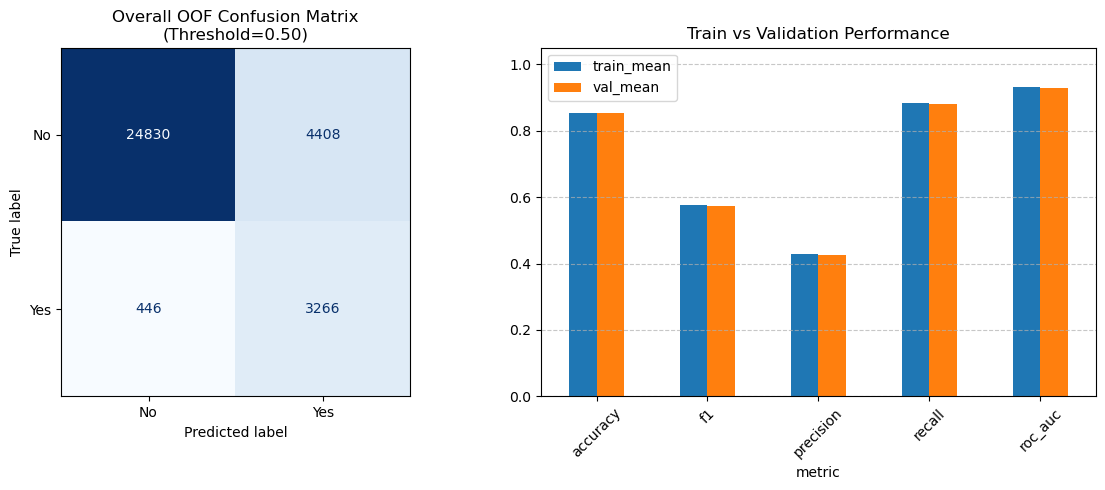

In [9]:
# 1. base model
base_logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
base_logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_logreg)
])

base_logreg_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_logreg_pipe, X_train, y_train, cv=5)

In [ ]:
# 2. Fine-tuning the model
param_grid_log = {
    'classifier__C': [0.01, 0.1, 0.5, 0.8, 1, 5, 10],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__class_weight': [None, 'balanced']
}

grid_log = GridSearchCV(base_logreg_pipe, param_grid_log, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1,return_train_score = True)
grid_log.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 0.5, 0.8, 1, 5, 10],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [179]:
df_rank_log = pd.DataFrame(grid_log.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

df_rank_log.iloc[0,0]

{'classifier__C': 0.5,
 'classifier__class_weight': 'balanced',
 'classifier__solver': 'lbfgs'}

In [152]:
print("Best parameters:", grid_log.best_params_)
print("Best AUC-ROC score:", grid_log.best_score_)

# best model
best_log_clf = grid_log.best_estimator_

Best parameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__solver': 'lbfgs'}
Best AUC-ROC score: 0.9289774390179442


Best threshold: 0.7217810815896891
{'min_precision': 0.5, 'min_recall': 0.7, 'precision': np.float64(0.5286334913112164), 'recall': np.float64(0.7211745689655172), 'f1': np.float64(0.6100729261622607), 'condition': 'precision>=0.5 & recall>=0.7 (f1)'}

 Log-Reg Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.895797,0.001167,0.895083,0.003234,0.000713,0.000796
f1,0.608857,0.003617,0.606210,0.010175,0.002647,0.004347
precision,0.527499,0.003926,0.525326,0.011020,0.002173,0.004119
recall,0.719895,0.003399,0.716855,0.017984,0.003040,0.004223
roc_auc,0.930396,0.000818,0.928977,0.003308,0.001419,0.001525


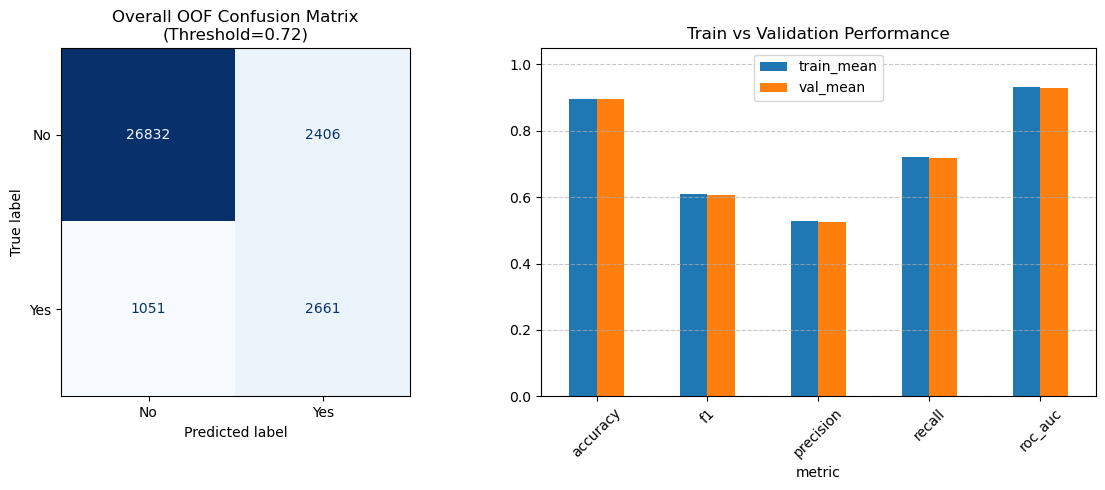

In [14]:
# obtain the best threshold (default rule: max f1 while keeping precision > 0.5, recall > 0.8/0.7/0.6)
best_thresh_log, t_info = search_best_threshold(y_train, best_log_clf.predict_proba(X_train)[:, 1])
print(f"Best threshold: {best_thresh_log}")
print(t_info)

# retrain the model with the best threshold, save to hist_log
print("\n Log-Reg Model Performance with the best threshold (Train + Val)")
hist_log = cv_classification_report_df(best_log_clf, X_train, y_train, cv=5, threshold=best_thresh_log)


### 3.2 SVC



 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.852815,0.000836,0.852322,0.003576,0.000493,0.000578
f1,0.573884,0.001597,0.571836,0.006428,0.002047,0.003567
precision,0.425828,0.001521,0.424672,0.006486,0.001156,0.002715
recall,0.879781,0.003304,0.875265,0.011074,0.004517,0.005134


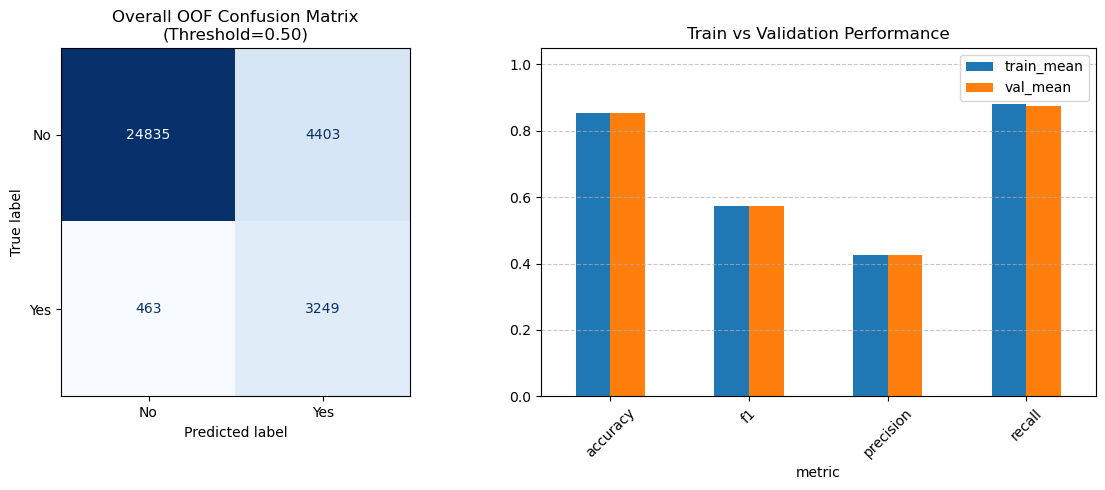

In [ ]:
from sklearn.svm import LinearSVC

# Use linearsvc instead of svc. (scaling inefficiency and high dimensionality)
base_linearsvc = LinearSVC(class_weight='balanced', random_state=42)

base_test_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_linearsvc)
])

base_test_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_test_pipe, X_train, y_train, cv=5, prob_opt = False)

# no overfitting, but more like underfitting.

# base_svc = SVC(probability=True, random_state=42, class_weight='balanced')
# base_svc_pipe = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', base_svc)
# ])

# base_svc_pipe.fit(X_train, y_train)

# hist = cv_classification_report_df(base_svc_pipe, X_train, y_train, cv=5)


In [546]:
# 2. Fine-tuning the model
print("\nTuning SVC...")

# param_grid = {
#     # "classifier__C": [0.01, 0.1, 1, 10],
#     'classifier__C': [0.01, 0.05, 0.1, 0.5, 1],
#     'classifier__class_weight': [None, "balanced"]
# }

param_grid = {
    'classifier__C': [0.01],
    'classifier__class_weight': ["balanced"]
}
grid_svc = GridSearchCV(base_svc_pipe, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose = 2, return_train_score=True)
grid_svc.fit(X_train, y_train)

print(f"Best Params: {grid_svc.best_params_}")
best_svc_clf = grid_svc.best_estimator_



Tuning SVC...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__C=0.01, classifier__class_weight=balanced; total time= 2.4min
[CV] END classifier__C=0.01, classifier__class_weight=balanced; total time= 2.5min
[CV] END classifier__C=0.01, classifier__class_weight=balanced; total time= 2.5min
[CV] END classifier__C=0.01, classifier__class_weight=balanced; total time= 2.5min
[CV] END classifier__C=0.01, classifier__class_weight=balanced; total time= 2.5min
Best Params: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced'}


In [545]:
# 3. check cv performance difference
df_rank_svc = pd.DataFrame(grid_svc.cv_results_).sort_values('rank_test_score')
df_rank_svc['gap'] = df_rank_svc['mean_train_score'] - df_rank_svc['mean_test_score']

param_cols = df_rank_svc.columns.str.startswith('param_classifier__')
df_rank_svc.iloc[:10].loc[:, df_rank_svc.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

,param_classifier__C,param_classifier__class_weight,mean_test_score,mean_train_score,gap
7,0.50,balanced,0.926183,0.951778,0.025595
5,0.10,balanced,0.921604,0.931843,0.010239
3,0.05,balanced,0.918640,0.927398,0.008758
9,1.00,balanced,0.917291,0.959995,0.042704
1,0.01,balanced,0.907328,0.912513,0.005186
8,1.00,None,0.385773,0.453125,0.067352
6,0.50,None,0.353985,0.398640,0.044656
4,0.10,None,0.259962,0.277479,0.017517
2,0.05,None,0.120148,0.134293,0.014145
0,0.01,None,0.000000,0.000000,0.000000


In [547]:

# 4. Confirm best model
print("Best parameters:", grid_svc.best_params_)
# print("Best AUC-ROC score:", rand_svc.best_score_)

# best model
best_svc_clf = grid_svc.best_estimator_



Best parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced'}



 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.906146,0.000746,0.905736,0.003275,0.000410,0.000452
f1,0.531123,0.008239,0.530324,0.012410,0.000799,0.001504
precision,0.607371,0.002759,0.605460,0.024533,0.001911,0.003147
recall,0.471983,0.012295,0.472510,0.019485,-0.000527,-0.001117


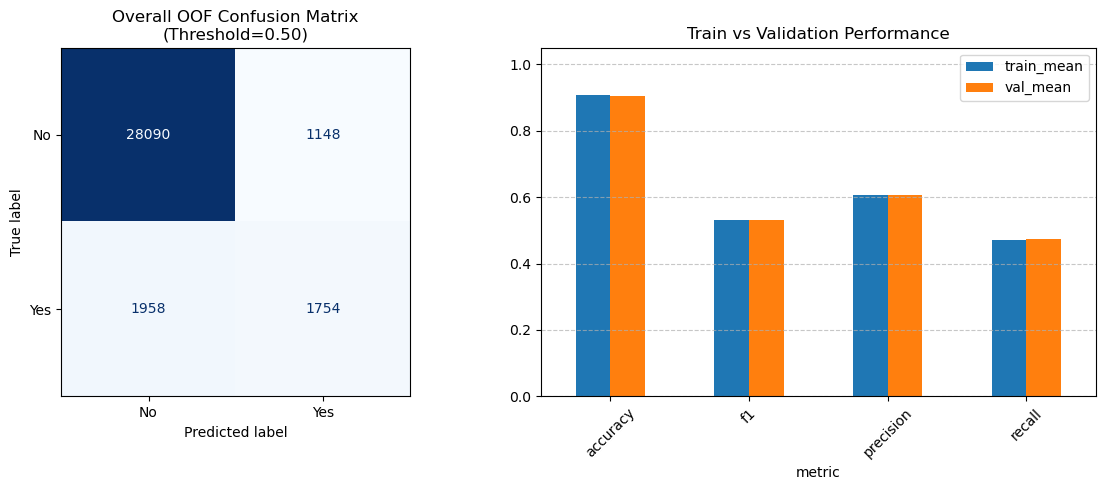

In [15]:
# 5. obtain the best threshold (default rule: max f1 while keeping precision > 0.5, recall > 0.8/0.7/0.6)
# best_thresh_svc, t_info = search_best_threshold(y_train, best_svc_clf.predict_proba(X_train)[:, 1])
# print(f"Best threshold: {best_thresh_svc}")
# print(t_info)

# retrain the model with the best threshold, save to hist_svc
# print("\n SVC Model Performance with the best threshold (Train + Val)")
hist_svc = cv_classification_report_df(best_svc_clf, X_train, y_train, cv=5, prob_opt = False)

# hist_svc['summary_df']


### 3.3 Decision Tree



 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,1.0,0.0,0.887102,0.006222,0.112898,0.112898
f1,1.0,0.0,0.488111,0.020792,0.511889,0.511889
precision,1.0,0.0,0.499566,0.028447,0.500434,0.500434
recall,1.0,0.0,0.477377,0.014765,0.522623,0.522623
roc_auc,1.0,0.0,0.708248,0.009655,0.291752,0.291752


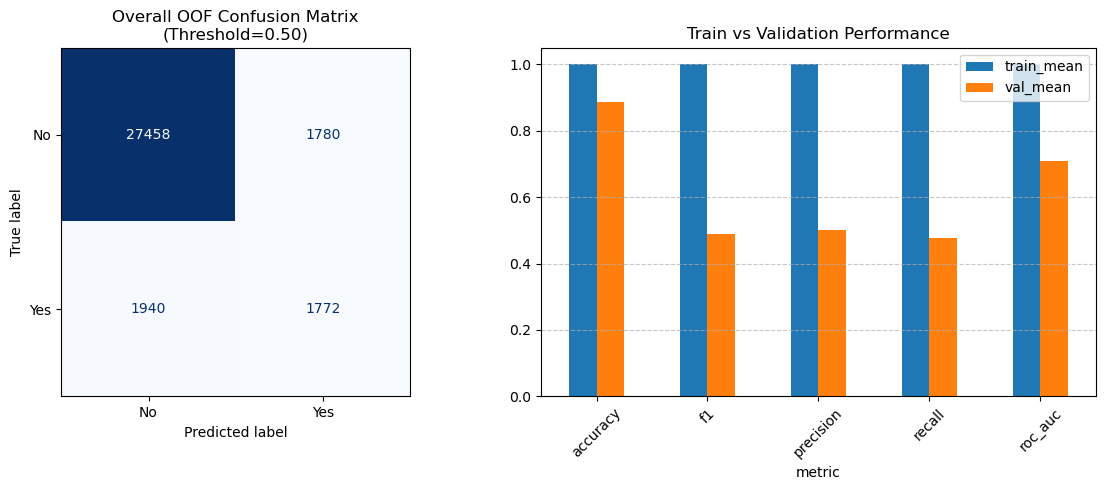

In [514]:
# 1. base model
base_dt = DecisionTreeClassifier(class_weight="balanced",random_state=42)

base_dt_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_dt)
])

base_dt_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_dt_pipe, X_train, y_train, cv=5)

# highly overfit


In [ ]:
# 2. Fine-tuning the model
print("\nTuning Decision Tree...")

# order 
# 1. max_depth
# 2. min_samples_leaf
# 3. min_samples_split
# 4. max_features

# param_grid_dt = {
    # 'classifier__max_depth': [None, 3, 5, 10, 15, 20] # -> around 5
    # 'classifier__max_depth': [3, 4, 5, 6, 7, 8] # 5 
# }

# param_grid_dt = {
    # 'classifier__min_samples_leaf': [1, 2, 5, 10, 20]
    # 'classifier__min_samples_leaf': [10, 15, 20, 25, 30] # refine beyond 20
    # 'classifier__min_samples_leaf': [21, 23, 25, 27, 29] # refine around 25 -> 25
# }

# split would be 50 automatically

param_grid_dt = {
    'classifier__max_features': [None, "sqrt", "log2", 0.5], # None
    'classifier__class_weight': [None, 'balanced'] # balanced
}

# param_grid_rf = {
#     'classifier__class_weight': ['balanced', None], # balanced
#     'classifier__n_estimators': [100, 200, 300, 400, 500] # 200
# }

grid_dt = GridSearchCV(step_dt_model, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose = 1, return_train_score=True)

start = time.perf_counter()
grid_dt.fit(X_train, y_train)
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")
step_dt_model = grid_dt.best_estimator_



Tuning Decision Tree...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training time: 1.22 seconds


In [528]:
# 3. check cv performance difference
df_rank_dt = pd.DataFrame(grid_dt.cv_results_).sort_values('rank_test_score')
df_rank_dt['gap'] = df_rank_dt['mean_train_score'] - df_rank_dt['mean_test_score']

param_cols = df_rank_dt.columns.str.startswith('param_classifier__')
df_rank_dt.iloc[:10].loc[:, df_rank_dt.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

,param_classifier__class_weight,param_classifier__max_features,mean_test_score,mean_train_score,gap
4,balanced,None,0.928049,0.934333,0.006285
7,balanced,0.5,0.920377,0.925641,0.005263
0,None,None,0.916469,0.922237,0.005768
3,None,0.5,0.911679,0.916893,0.005215
1,None,sqrt,0.832233,0.838449,0.006216
5,balanced,sqrt,0.819000,0.827056,0.008056
6,balanced,log2,0.759260,0.772673,0.013413
2,None,log2,0.748753,0.758980,0.010227


In [529]:
# 4. Confirm best model
print("Best parameters:", grid_dt.best_params_)
print("Best AUC-ROC score:", grid_dt.best_score_)

# best model
best_dt_clf = grid_dt.best_estimator_

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_features': None}
Best AUC-ROC score: 0.9280486186590171


Best threshold: 0.8155648535564857
{'min_precision': 0.5, 'min_recall': 0.7, 'precision': np.float64(0.5487547488391726), 'recall': np.float64(0.7004310344827587), 'f1': np.float64(0.6153846153846154), 'condition': 'precision>=0.5 & recall>=0.7 (f1)'}

 Decision Tree Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.902807,0.004407,0.897572,0.008094,0.005235,0.005799
f1,0.611435,0.006282,0.592721,0.011193,0.018714,0.030607
precision,0.557884,0.020549,0.539807,0.030615,0.018077,0.032403
recall,0.679484,0.046068,0.661368,0.045681,0.018116,0.026661
roc_auc,0.934333,0.000575,0.928049,0.004386,0.006285,0.006726


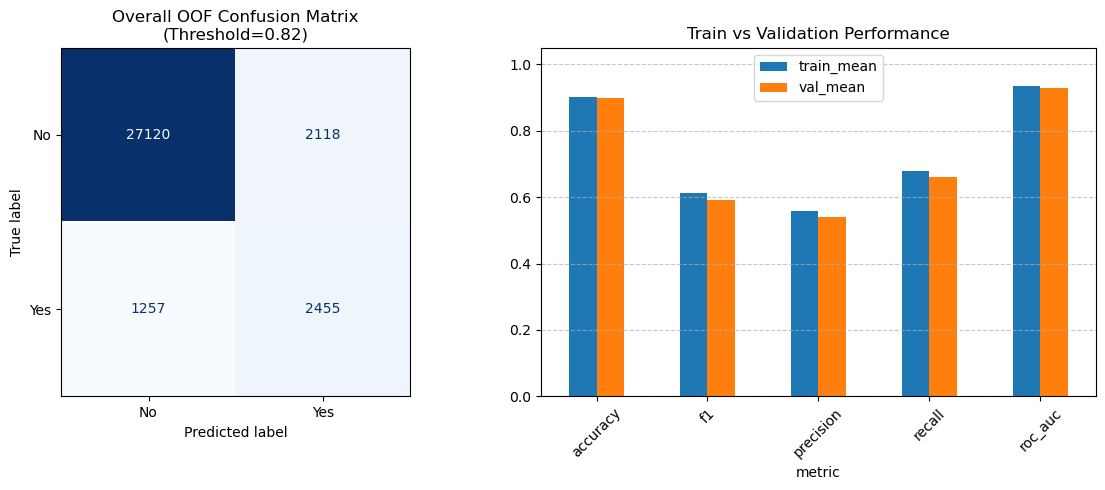

In [530]:
# 5. obtain the best threshold (default rule: max f1 while keeping precision > 0.5, recall > 0.8/0.7/0.6)
best_thresh_dt, t_info = search_best_threshold(y_train, best_dt_clf.predict_proba(X_train)[:, 1])
print(f"Best threshold: {best_thresh_dt}")
print(t_info)
 
# retrain the model with the best threshold, save to hist_log
print("\n Decision Tree Model Performance with the best threshold (Train + Val)")
hist_dt = cv_classification_report_df(best_dt_clf, X_train, y_train, cv=5, threshold=best_thresh_dt)


In [18]:
hist_dt['summary_df']

,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.902807,0.004407,0.897572,0.008094,0.005235,0.005799
f1,0.611435,0.006282,0.592721,0.011193,0.018714,0.030607
precision,0.557884,0.020549,0.539807,0.030615,0.018077,0.032403
recall,0.679484,0.046068,0.661368,0.045681,0.018116,0.026661
roc_auc,0.934333,0.000575,0.928049,0.004386,0.006285,0.006726


### 3.4 Random Forest


 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.999992,1.696561e-05,0.906191,0.001893,0.093801,0.093802
f1,0.999966,7.530116e-05,0.495089,0.011960,0.504878,0.504895
precision,1.000000,0.000000e+00,0.629075,0.015005,0.370925,0.370925
recall,0.999933,1.505770e-04,0.408404,0.015025,0.591529,0.591569
roc_auc,1.000000,5.551115e-17,0.936841,0.003758,0.063159,0.063159


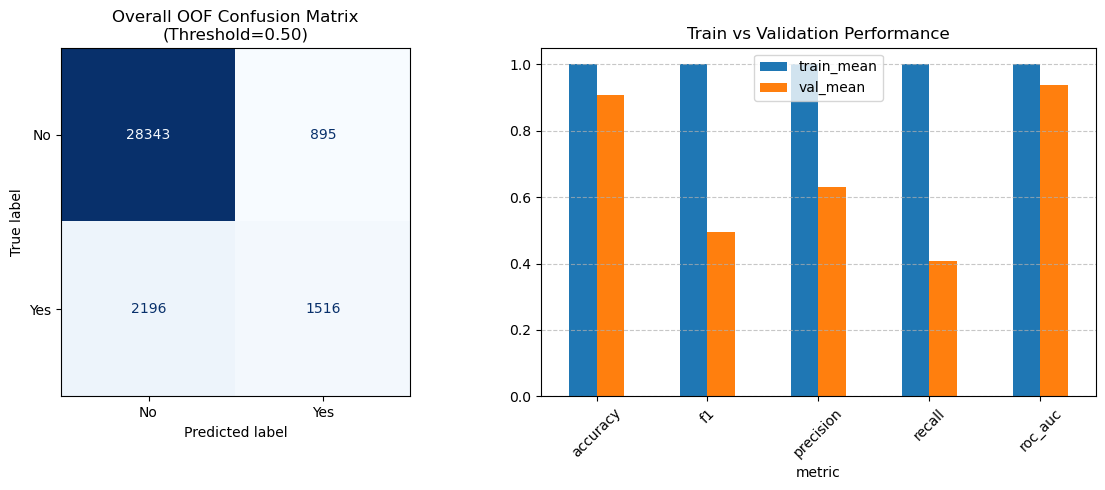

In [ ]:
# 1. base model
base_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

base_rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_rf)
])

base_rf_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_rf_pipe, X_train, y_train, cv=5)

# highly overfit


In [ ]:
# 2. Fine-tuning the model
print("\nTuning Random Forest...")

# order 
# 1) max_depth
# 2) min_samples_leaf
# 3) max_features
# 4) n_estimators
# param_grid_rf = {
#     'classifier__max_depth': [1, 3, 5, 8, 10] # -> 5
# }

# param_grid_rf = {
#     'classifier__max_depth': [5],
#     'classifier__min_samples_leaf': [1,2,5, 7, 10] # -> 7
# }

# param_grid_rf = {
#     'classifier__min_samples_split': [2,4,6,8] # all same performance
# }

# param_grid_rf = {
#     'classifier__max_features': ["sqrt", "log2"],
#     'classifier__min_samples_leaf': [7]
# }

param_grid_rf = {
    'classifier__class_weight': ['balanced', None], # balanced
    'classifier__n_estimators': [100, 200, 300, 400, 500] # 200
}

grid_rf = GridSearchCV(step_rf_model, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose = 1, return_train_score=True)

start = time.perf_counter()
grid_rf.fit(X_train, y_train)
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")
step_rf_model = grid_rf.best_estimator_



Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 19.99 seconds


In [509]:
# 3. check cv performance difference
df_rank_rf = pd.DataFrame(grid_rf.cv_results_).sort_values('rank_test_score')
df_rank_rf['gap'] = df_rank_rf['mean_train_score'] - df_rank_rf['mean_test_score']

param_cols = df_rank_rf.columns.str.startswith('param_classifier__')
df_rank_rf.iloc[:10].loc[:, df_rank_rf.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

# df_rank_xgb[df_rank_xgb['param_classifier__max_depth'] < 4].iloc[:10].loc[:, df_rank_xgb.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

,param_classifier__class_weight,param_classifier__n_estimators,mean_test_score,mean_train_score,gap
1,balanced,200,0.924630,0.928938,0.004307
4,balanced,500,0.924411,0.928768,0.004357
3,balanced,400,0.924371,0.928665,0.004294
2,balanced,300,0.924216,0.928480,0.004264
0,balanced,100,0.924027,0.928255,0.004229
6,None,200,0.921525,0.926291,0.004766
9,None,500,0.921507,0.926139,0.004633
8,None,400,0.921449,0.926173,0.004724
7,None,300,0.921163,0.925865,0.004702
5,None,100,0.920667,0.925576,0.004910


In [510]:
# 4. Confirm best model
print("Best parameters:", grid_rf.best_params_)
print("Best AUC-ROC score:", grid_rf.best_score_)

# best model
best_rf_clf = grid_rf.best_estimator_

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__n_estimators': 200}
Best AUC-ROC score: 0.9246301732226414


Best threshold: 0.5997808198717738
{'min_precision': 0.5, 'min_recall': 0.6, 'precision': np.float64(0.5004492362982929), 'recall': np.float64(0.6002155172413793), 'f1': np.float64(0.5458108770210681), 'condition': 'precision>=0.5 & recall>=0.6 (f1)'}

 Random Forest Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.889310,0.002261,0.886222,0.004317,0.003088,0.003472
f1,0.565017,0.013072,0.553326,0.010886,0.011691,0.020691
precision,0.506901,0.007807,0.496530,0.015474,0.010371,0.020459
recall,0.638538,0.025533,0.625530,0.021079,0.013008,0.020371
roc_auc,0.928938,0.001191,0.924630,0.002961,0.004307,0.004637


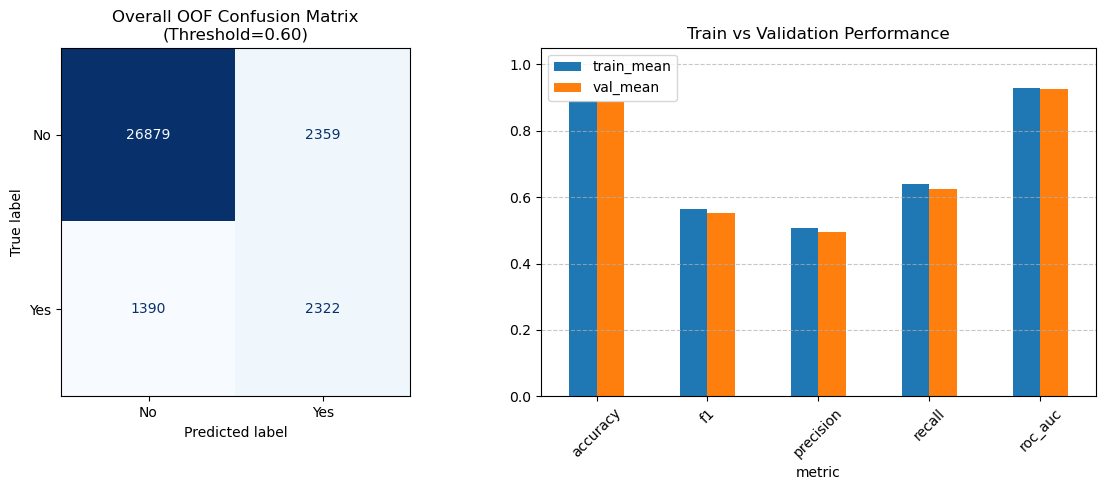

In [511]:
# 5. obtain the best threshold (default rule: max f1 while keeping precision > 0.5, recall > 0.8/0.7/0.6)
best_thresh_rf, t_info = search_best_threshold(y_train, best_rf_clf.predict_proba(X_train)[:, 1])
print(f"Best threshold: {best_thresh_rf}")
print(t_info)
 
# retrain the model with the best threshold, save to hist_log
print("\n Random Forest Model Performance with the best threshold (Train + Val)")
hist_rf = cv_classification_report_df(best_rf_clf, X_train, y_train, cv=5, threshold=best_thresh_rf)


In [20]:
hist_rf['summary_df']


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.889310,0.002261,0.886222,0.004317,0.003088,0.003472
f1,0.565017,0.013072,0.553326,0.010886,0.011691,0.020691
precision,0.506901,0.007807,0.496530,0.015474,0.010371,0.020459
recall,0.638538,0.025533,0.625530,0.021079,0.013008,0.020371
roc_auc,0.928938,0.001191,0.924630,0.002961,0.004307,0.004637


### 3.5 XGBoost


 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.964734,0.000847,0.908103,0.004095,0.056631,0.058701
f1,0.833797,0.004971,0.563659,0.011970,0.270138,0.323986
precision,0.888701,0.004322,0.607059,0.026337,0.281642,0.316914
recall,0.785358,0.010187,0.526664,0.013982,0.258694,0.329397
roc_auc,0.987644,0.000530,0.940221,0.004271,0.047422,0.048016


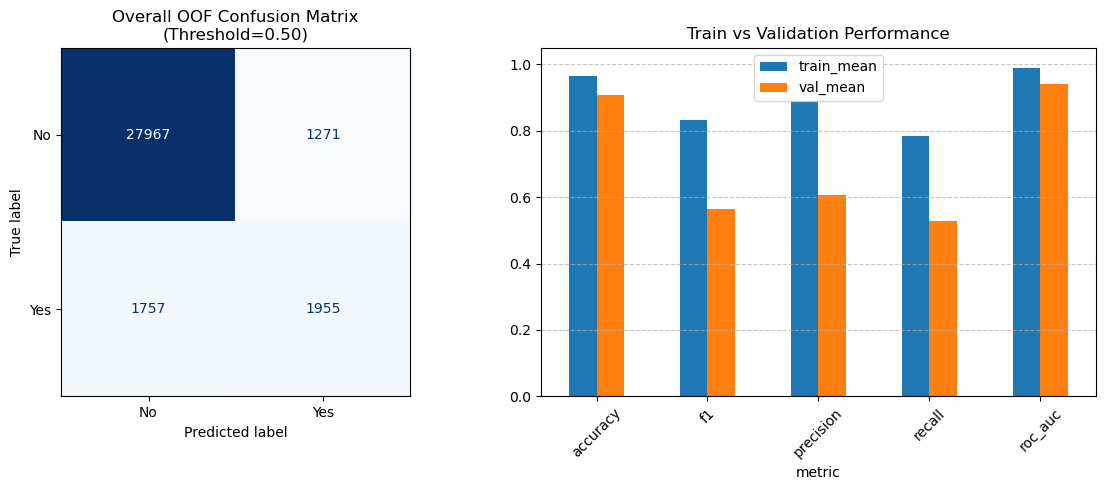

In [439]:
# 1. base model
base_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
base_xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_xgb)
])

base_xgb_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_xgb_pipe, X_train, y_train, cv=5)


In [ ]:
# Weight for class imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
# scale_pos_weight

# 2. Step by step fine-tuning the model

# Model capacity (gamma, max_depth)
# param_xgb = {
#     'classifier__gamma': [0, 0.1, 0.2, 0.3], # -> 0
#     'classifier__max_depth': [3], #[1,2,3,4], #  -> 3 is better for gap.
#     'classifier__min_child_weight': [1, 2, 3, 5] # -> 5
# }

# Tree # and learning rate
# param_xgb = {
#     "classifier__eta": [0.005, 0.01, 0.03, 0.05, 0.08, 0.1], #0.05
#     "classifier__n_estimators": [200, 400] #400
# }

# Sampling (generalization)
# param_xgb = {
#     'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], # -> 1
#     'classifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1] # -> 1
# }

# Class weight 
# param_xgb = {
#     'classifier__scale_pos_weight': [None, scale_pos_weight, 10]} # None

# Regularization
param_xgb = {
    'classifier__reg_lambda': [0, 0.1, 0.5, 1.0, 5.0], # 0.1
    'classifier__reg_alpha': [0.0, 0.1, 0.2, 0.5] #0.1
}

grid_xgb = GridSearchCV(step_xgb_model, param_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1,return_train_score = True)

start = time.perf_counter()
grid_xgb.fit(X_train, y_train)
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")
step_xgb_model = grid_xgb.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training time: 8.05 seconds


In [474]:
# 3. check cv performance difference
df_rank_xgb = pd.DataFrame(grid_xgb.cv_results_).sort_values('rank_test_score')
df_rank_xgb['gap'] = df_rank_xgb['mean_train_score'] - df_rank_xgb['mean_test_score']

param_cols = df_rank_xgb.columns.str.startswith('param_classifier__')
df_rank_xgb.iloc[:10].loc[:, df_rank_xgb.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

# df_rank_xgb[df_rank_xgb['param_classifier__max_depth'] < 4].iloc[:10].loc[:, df_rank_xgb.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

,param_classifier__reg_alpha,param_classifier__reg_lambda,mean_test_score,mean_train_score,gap
6,0.1,0.1,0.943782,0.953308,0.009525
2,0.0,0.5,0.943755,0.953287,0.009532
11,0.2,0.1,0.943714,0.953363,0.009649
1,0.0,0.1,0.943694,0.953349,0.009654
12,0.2,0.5,0.943672,0.953170,0.009498
0,0.0,0.0,0.943666,0.953392,0.009726
5,0.1,0.0,0.943658,0.953386,0.009728
3,0.0,1.0,0.943658,0.952998,0.009340
16,0.5,0.1,0.943610,0.953202,0.009591
18,0.5,1.0,0.943599,0.952892,0.009293


In [475]:
# 4. Confirm best model
print("Best parameters:", grid_xgb.best_params_)
print("Best AUC-ROC score:", grid_xgb.best_score_)

# best model
best_xgb_clf = grid_xgb.best_estimator_

Best parameters: {'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.1}
Best AUC-ROC score: 0.9437824069229397


Best threshold: 0.28980571031570435

XGBoost Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.907496,0.001339,0.901244,0.005250,0.006252,0.006889
f1,0.663340,0.003859,0.639638,0.012894,0.023702,0.035731
precision,0.562183,0.004562,0.543586,0.018029,0.018597,0.033080
recall,0.808930,0.005785,0.777472,0.014074,0.031458,0.038889
roc_auc,0.953308,0.000657,0.943782,0.003139,0.009525,0.009992


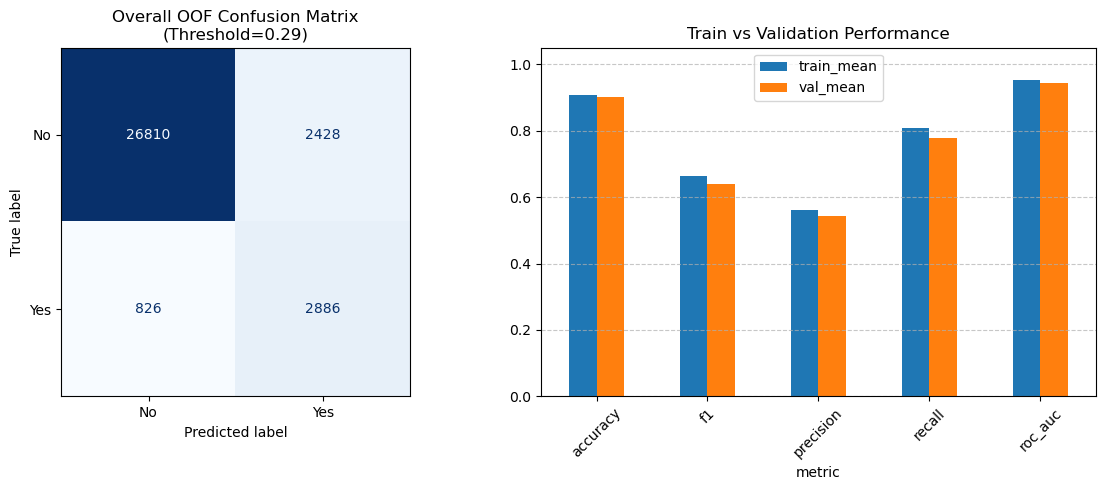

In [697]:
# 5. obtain the best threshold
best_thresh_xgb, info_xgb = search_best_threshold(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
print(f"Best threshold: {best_thresh_xgb}")

# obtain the train/val performance with the best threshold
print("\nXGBoost Model Performance with the best threshold (Train + Val)")
hist_xgb = cv_classification_report_df(best_xgb_clf, X_train, y_train, cv=5, threshold=best_thresh_xgb)

In [22]:
hist_xgb['summary_df']

,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.907496,0.001339,0.901244,0.005250,0.006252,0.006889
f1,0.663340,0.003859,0.639638,0.012894,0.023702,0.035731
precision,0.562183,0.004562,0.543586,0.018029,0.018597,0.033080
recall,0.808930,0.005785,0.777472,0.014074,0.031458,0.038889
roc_auc,0.953308,0.000657,0.943782,0.003139,0.009525,0.009992


### 3.6 LGBM


 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.878452,0.002774,0.865220,0.006024,0.013232,0.015063
f1,0.643004,0.004917,0.605285,0.011278,0.037719,0.058661
precision,0.480544,0.005813,0.451869,0.012205,0.028675,0.059672
recall,0.971511,0.001869,0.916755,0.006006,0.054757,0.056362
roc_auc,0.964637,0.000950,0.944902,0.003237,0.019735,0.020459


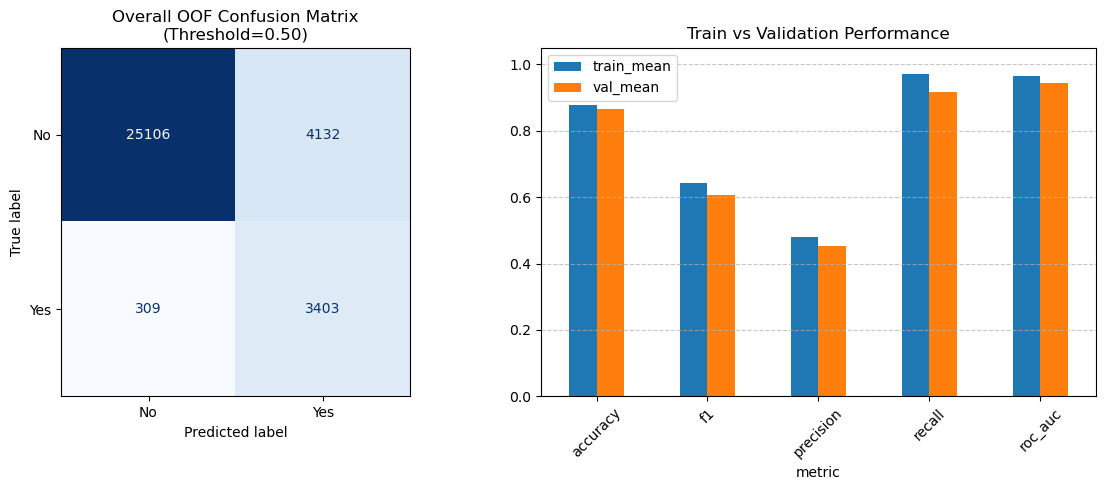

In [154]:
# 1. base model
base_lgbm = LGBMClassifier(
    random_state=42, verbose=-1, importances_type='gain',
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    subsample=1,
    colsample_bytree=1,
    class_weight='balanced')

base_lgbm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_lgbm)
])

base_lgbm_pipe.fit(X_train, y_train)

hist = cv_classification_report_df(base_lgbm_pipe, X_train, y_train, cv=5)


In [ ]:
# Weight for class imbalance
# scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
# scale_pos_weight

# 2. Fine-tuning the model
# param_dist_lgbm = {
#     'classifier__n_estimators': [100, 200, 500],
#     'classifier__learning_rate': [0.01, 0.05, 0.1],
#     'classifier__num_leaves': [30, 50, 100],
#     'classifier__max_depth': [-1, 10, 20],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0],
#     'classifier__class_weight': ['balanced', None]
# }


# (1) Capacity (num_leaves, max_depth)
# (2) Learning (learning_rate, n_estimators)
# (3) Sampling/Reg (subsample, colsample_bytree)
# (4) Imbalance (class_weight)


# Step 1: Tree capacity (num_leaves, max_depth)
# param_dist_lgbm = {
#     'classifier__num_leaves': [15, 31, 63, 127] # 15-63.
# }

# param_dist_lgbm = {
#     'classifier__num_leaves': [10, 15, 31, 47, 63], -> 15
#     'classifier__max_depth': [4, 5, 6, 7] ->7
# }

# Step 2: Learning (learning_rate, n_estimators)
# param_dist_lgbm = {
#     'classifier__learning_rate': [0.01, 0.03, 0.05, 0.1], -> 0.05
#     'classifier__n_estimators': [200, 400, 600] -> 200
# }

# Step 3: Sampling/Reg (subsample, colsample_bytree)
# param_dist_lgbm = {
#     'classifier__subsample': [0.5, 0.8, 1.0], -> all the same. 0.5
#     'classifier__colsample_bytree': [0.5, 0.8, 1.0] -> 0.8
# }

# Step 4: Imbalance (class_weight) + Regularization (reg_alpha, reg_lambda)
param_dist_lgbm = {
    # 'classifier__class_weight': ['balanced', None], -> 'balance'
    'classifier__reg_alpha': [0.4, 0.5, 0.6, 0.7] # -> 0.5
    # 'classifier__reg_lambda': [0] # -> near 0
}

rand_lgbm = GridSearchCV(
    step_model,
    param_grid=param_dist_lgbm,
    cv=5,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1, 
)

start = time.perf_counter()
rand_lgbm.fit(X_train, y_train)
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")
step_model = rand_lgbm.best_estimator_

/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Training time: 9.99 seconds


In [432]:
# 3. check cv performance difference
df_rank_lgbm = pd.DataFrame(rand_lgbm.cv_results_).sort_values('rank_test_score')
df_rank_lgbm['gap'] = df_rank_lgbm['mean_train_score'] - df_rank_lgbm['mean_test_score']

param_cols = df_rank_lgbm.columns.str.startswith('param_classifier__')
df_rank_lgbm.iloc[:10].loc[:, df_rank_lgbm.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

# df_rank_lgbm[df_rank_lgbm['param_classifier__max_depth'] < 4].iloc[:10].loc[:, df_rank_lgbm.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]

,param_classifier__reg_alpha,mean_test_score,mean_train_score,gap
1,0.5,0.945525,0.956462,0.010938
2,0.6,0.945301,0.956465,0.011164
3,0.7,0.945269,0.956380,0.011111
0,0.4,0.945161,0.956518,0.011358


In [741]:
# 4. Confirm best model
print("Best parameters:", rand_lgbm.best_params_)
print("Best AUC-ROC score:", rand_lgbm.best_score_)

# best model
best_lgbm_clf = rand_lgbm.best_estimator_


Best parameters: {'classifier__reg_alpha': 0.5}
Best AUC-ROC score: 0.9455247592262419


In [434]:
rand_lgbm.estimator.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 15,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.5,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'importances_type': 'gain'}

Best threshold: 0.7544693069918953
{'min_precision': 0.5, 'min_recall': 0.8, 'precision': np.float64(0.5613648871766649), 'recall': np.float64(0.8243534482758621), 'f1': np.float64(0.6679035250463823), 'condition': 'precision>=0.5 & recall>=0.8 (f1)'}

 LGBM Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.908680,0.001343,0.901184,0.005609,0.007496,0.008250
f1,0.670685,0.004214,0.643012,0.013186,0.027674,0.041262
precision,0.564805,0.004289,0.542741,0.018725,0.022064,0.039065
recall,0.825431,0.004327,0.789325,0.012755,0.036105,0.043741
roc_auc,0.956462,0.000880,0.945525,0.003485,0.010938,0.011435


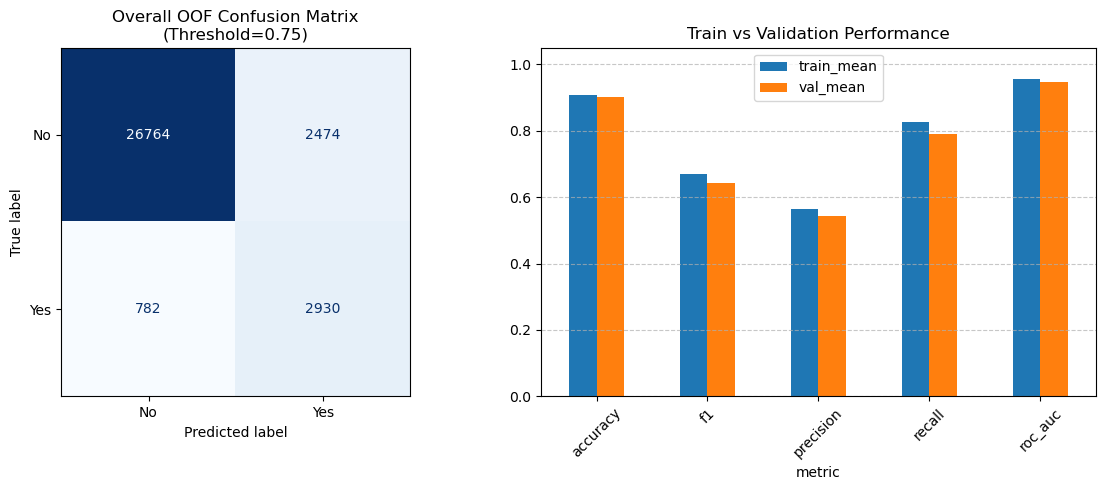

In [215]:
# 5. obtain the best threshold (default rule: max f1 while keeping precision > 0.5, recall > 0.8/0.7/0.6)
best_thresh_lgbm, t_info = search_best_threshold(y_train, best_lgbm_clf.predict_proba(X_train)[:, 1])
print(f"Best threshold: {best_thresh_lgbm}")
print(t_info)

# pull the model performance (prediction with the best threshold), save to hist_log
print("\n LGBM Model Performance with the best threshold (Train + Val)")
hist_lgbm = cv_classification_report_df(best_lgbm_clf, X_train, y_train, cv=5, threshold=best_thresh_lgbm)


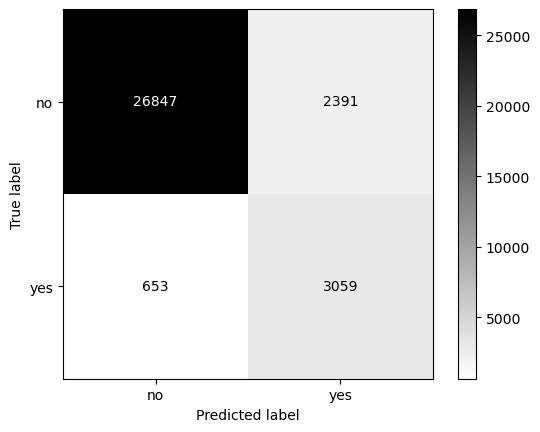

In [24]:
# Display 
disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_lgbm_clf.predict_proba(X_train)[:,1] > best_thresh_lgbm).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

In [700]:
best_lgbm_clf.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 15,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.5,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'importances_type': 'gain'}

In [25]:
hist_lgbm['summary_df']


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.908680,0.001343,0.901184,0.005609,0.007496,0.008250
f1,0.670685,0.004214,0.643012,0.013186,0.027674,0.041262
precision,0.564805,0.004289,0.542741,0.018725,0.022064,0.039065
recall,0.825431,0.004327,0.789325,0.012755,0.036105,0.043741
roc_auc,0.956462,0.000880,0.945525,0.003485,0.010938,0.011435


**Other visualizations**

- PR Curve

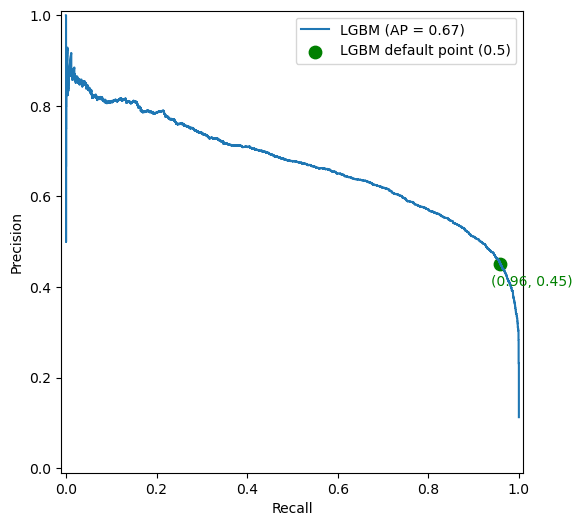

In [29]:
# Plot PR curve
# PR curve points (pos_label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
# prec_arr, rec_arr, thresh_arr = precision_recall_curve(y_train, best_xgb_clf.predict_proba(X_train)[:,1])

# default point's prec and rec
prec, rec, _, _ = precision_recall_fscore_support(y_train, best_lgbm_clf.predict(X_train), average="binary")

fig, ax = plt.subplots(figsize=(8, 6))
disp2 = PrecisionRecallDisplay.from_estimator(best_lgbm_clf, X_train, y_train, ax=ax, name="LGBM")

ax.scatter(rec, prec, color="green", s=80, label="LGBM default point (0.5)")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">4. Model Selection</p>

<a id="6"></a>



We select the model with the best cross-validation F1 score - LightGBM (slightly better) as the final model.

In [ ]:
cv_logs_by_model = {
    "logreg": hist_log,
    "linearsvc": hist_svc,
    "decision_tree": hist_dt,
    "random_forest": hist_rf,
    "xgb": hist_xgb,
    "lgbm": hist_lgbm,
}

In [31]:
hist_log['overall_confusion_matrix']

array([[26832,  2406],
       [ 1051,  2661]])

In [197]:
# convert cv_logs_by_model's summary_df to selection_metrics
def build_model_selection_table(logs_by_model, confusion=False, metrics=["roc_auc", "f1", "precision", "recall", "accuracy"]):
    rows = []

    for model_name, log in logs_by_model.items():
        summary = log["summary_df"] 
        row = {"model": model_name}
        
        # pull train/val/gap means for each metric
        for m in metrics:
            if m in summary.index:
                row[f'train_{m}'] = float(summary.loc[m, 'train_mean'])
                row[f'val_{m}']   = float(summary.loc[m, 'val_mean'])
                row[f'gap_{m}']   = float(summary.loc[m, 'gap_mean'])
            else:
                row[f'train_{m}'] = np.nan
                row[f'val_{m}']   = np.nan
                row[f'gap_{m}']   = np.nan

        # optionally add confusion-matrix-derived stats from OOF preds
        if confusion and 'overall_confusion_matrix' in log:
            cm = log['overall_confusion_matrix']
            tn, fp, fn, tp = cm.ravel()
            row.update({
                "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp), "total": int(tn + fp + fn + tp),
                "oof_fpr": fp / (fp + tn) if (fp + tn) else np.nan,
                "oof_tpr": tp / (tp + fn) if (tp + fn) else np.nan,  # recall
            })

        rows.append(row)

    df = pd.DataFrame(rows).set_index('model')

    df = df.sort_values(['val_roc_auc', "val_f1"], ascending=False)

    return df

selection_metrics =build_model_selection_table(cv_logs_by_model)
selection_metrics

,train_roc_auc,val_roc_auc,gap_roc_auc,train_f1,val_f1,gap_f1,train_precision,val_precision,gap_precision,train_recall,val_recall,gap_recall,train_accuracy,val_accuracy,gap_accuracy
model,,,,,,,,,,,,,,,
lgbm,0.956462,0.945525,0.010938,0.670685,0.643012,0.027674,0.564805,0.542741,0.022064,0.825431,0.789325,0.036105,0.908680,0.901184,0.007496
xgb,0.953308,0.943782,0.009525,0.663340,0.639638,0.023702,0.562183,0.543586,0.018597,0.808930,0.777472,0.031458,0.907496,0.901244,0.006252
logreg,0.930396,0.928977,0.001419,0.608857,0.606210,0.002647,0.527499,0.525326,0.002173,0.719895,0.716855,0.003040,0.895797,0.895083,0.000713
decision_tree,0.934333,0.928049,0.006285,0.611435,0.592721,0.018714,0.557884,0.539807,0.018077,0.679484,0.661368,0.018116,0.902807,0.897572,0.005235
random_forest,0.928938,0.924630,0.004307,0.565017,0.553326,0.011691,0.506901,0.496530,0.010371,0.638538,0.625530,0.013008,0.889310,0.886222,0.003088
linearsvc,NaN,NaN,NaN,0.531123,0.530324,0.000799,0.607371,0.605460,0.001911,0.471983,0.472510,-0.000527,0.906146,0.905736,0.000410


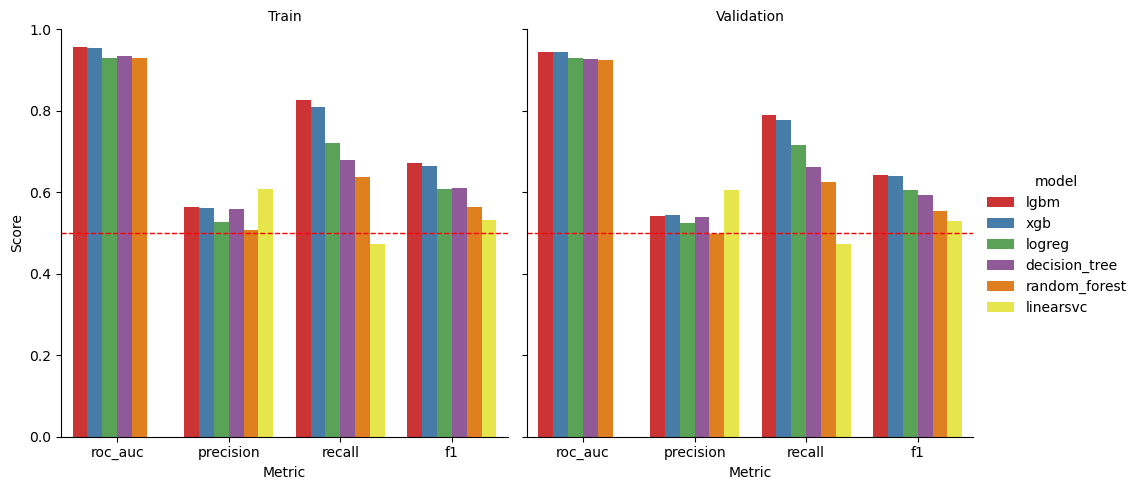

In [203]:
# converting selection_metrics from wide to long for main metrics plotting
df_plot = selection_metrics.reset_index()

metrics_to_plot = ["val_roc_auc", "val_precision", "val_recall", "val_f1",'train_precision', 'train_recall', 'train_f1', 'train_roc_auc']

plot_df = df_plot.melt(
    id_vars= "model",
    value_vars=metrics_to_plot,
    var_name="metric",
    value_name="value"
)

plot_df

plot_df["kind"] = plot_df["metric"].apply(lambda s: "Validation" if s.startswith("val_") else "Train")
plot_df["metric"] = plot_df["metric"].str.replace("val_", "").str.replace("train_", "")

g = sns.catplot(data=plot_df,kind="bar",x="metric",y="value",col="kind",
    col_order=["Train", "Validation"],hue="model",palette="Set1",errorbar=None)

g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Score")
g.set(ylim=(0, 1))

# Add threshold line to EACH subplot
for ax in g.axes.flat:
    ax.axhline(0.5, color="red", linestyle="--", linewidth=1)

plt.show()

In [209]:
selection_metrics[['val_roc_auc', 'train_roc_auc', 'gap_roc_auc', 'val_recall', 'train_recall', 'gap_recall']]

,val_roc_auc,train_roc_auc,gap_roc_auc,val_recall,train_recall,gap_recall
model,,,,,,
lgbm,0.945525,0.956462,0.010938,0.789325,0.825431,0.036105
xgb,0.943782,0.953308,0.009525,0.777472,0.808930,0.031458
logreg,0.928977,0.930396,0.001419,0.716855,0.719895,0.003040
decision_tree,0.928049,0.934333,0.006285,0.661368,0.679484,0.018116
random_forest,0.924630,0.928938,0.004307,0.625530,0.638538,0.013008
linearsvc,NaN,NaN,NaN,0.472510,0.471983,-0.000527


In [211]:
best_model_name = 'lgbm'

final_model = best_lgbm_clf

# Predict on Test Set
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("--- Final Test Set Evaluation (threshold = 0.5) ---")
print(classification_report(y_test, (y_test_proba>=0.5).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_test_proba>=0.5).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (y_test_proba>=0.5).astype(int)):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")

--- Final Test Set Evaluation (threshold = 0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7310
           1       0.45      0.95      0.61       928

    accuracy                           0.86      8238
   macro avg       0.72      0.90      0.76      8238
weighted avg       0.93      0.86      0.88      8238

Confusion Matrix:
 [[6217 1093]
 [  51  877]]
Accuracy: 0.8611
AUC-ROC: 0.9527


In [219]:
print(f"--- Final Test Set Evaluation (threshold = {best_thresh_lgbm:.2f}) ---")
print(classification_report(y_test, (y_test_proba>=best_thresh_lgbm).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_test_proba>=best_thresh_lgbm).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (y_test_proba>=best_thresh_lgbm).astype(int)):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")

--- Final Test Set Evaluation (threshold = 0.75) ---
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7310
           1       0.56      0.82      0.67       928

    accuracy                           0.91      8238
   macro avg       0.77      0.87      0.81      8238
weighted avg       0.93      0.91      0.92      8238

Confusion Matrix:
 [[6719  591]
 [ 168  760]]
Accuracy: 0.9079
AUC-ROC: 0.9527


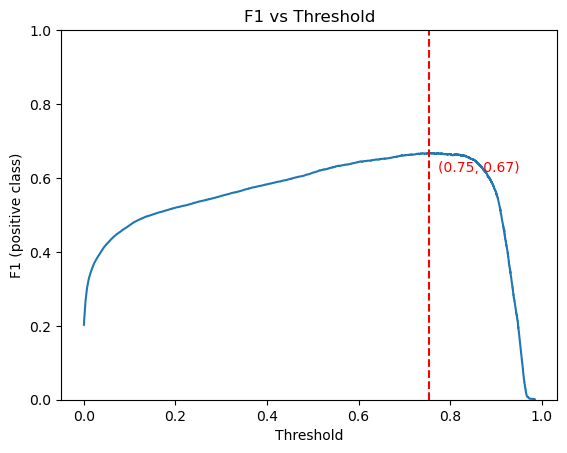

In [ ]:
# Plot the F1 vs Threshold curve for the best LGBM model
aprecision, arecall, arr_thresh = precision_recall_curve(y_train, best_lgbm_clf.predict_proba(X_train)[:,1])

af1 = 2 * aprecision[:-1] * arecall[:-1] / (aprecision[:-1] + arecall[:-1] + 1e-12)
best_idx = np.argmax(af1)
athres = arr_thresh[best_idx]
best_precision = aprecision[best_idx]
best_recall = arecall[best_idx]

plt.plot(arr_thresh, af1)
plt.axvline(athres, color="red", linestyle="--")
plt.ylim(0, 1)
plt.text(athres + 0.02, af1[best_idx] - 0.05, f"({athres:.2f}, {af1[best_idx]:.2f})", color="red")
plt.xlabel("Threshold")
plt.ylabel("F1 (positive class)")
plt.title("F1 vs Threshold")
plt.show()

Text(0.5, 1.0, 'After Threshold=0.75')

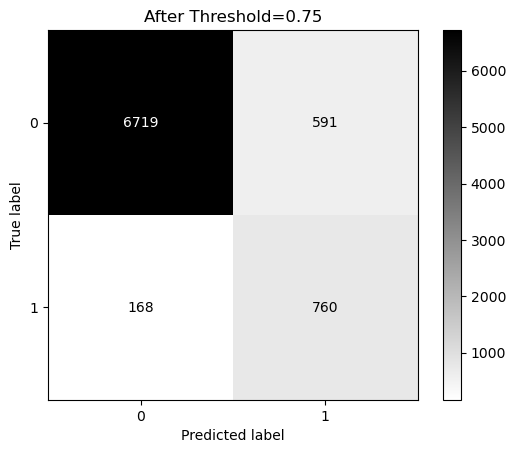

In [ ]:
# Visualization Confusion Matrix
fin_disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_proba >= best_thresh_lgbm, cmap = 'gray_r')
fin_disp.ax_.grid(False)
fin_disp.ax_.set_title(f'Final Model ({best_model_name}) Test Data Confusion Matrix at Threshold={best_thresh_lgbm:.2f}')

### Considerations for SMOTE:

1. Given the significant class imbalance in the dataset, we explore the use of SMOTE to oversample the minority class and assess its impact on model performance.

2. Tree-based models such as LightGBM and Random Forest are generally less sensitive to class imbalance due to their split criteria and ensemble nature. In contrast, linear models such as Logistic Regression and margin-based models such as SVM are typically more sensitive to class imbalance and may benefit more directly from resampling techniques.

3. Not fine-tuning the hyperparameters of the models. Just running a cloned model from the previous section to get a sense of the performance.

In [360]:
# Apply SMOTE to training data only
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OrdinalEncoder

# ordinal encoding for categorical features
# otherwise won't work in SMOTE which requires a numeric input. The imputation would gives non-integer inputs 
# SMOTENC won't impute, but it can't trace back the original category from a range of 1/0s 

encoder = OrdinalEncoder() 
X_train_encoded = X_train.copy()
X_train_encoded[categorical_features] = encoder.fit_transform(X_train[categorical_features])


In [361]:
# SMOTE oversampling
cat_indices = [X_train_encoded.columns.get_loc(col) for col in categorical_features]

smote_nc = SMOTENC(
    categorical_features=cat_indices,
    random_state=42
)

X_res, y_res = smote_nc.fit_resample(X_train_encoded, y_train)

y_res.value_counts()

y
0    29238
1    29238
Name: count, dtype: int64

In [ ]:
# 1. LGBM
new_m = clone(best_lgbm_clf)
new_m.named_steps['classifier'].set_params(class_weight=None)
new_m.fit(X_train, y_train)

print(confusion_matrix(y_test, new_m.predict(X_test)))
print(classification_report(y_test, new_m.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, new_m.predict_proba(X_test)[:, 1]))
# the boosting models don't benefit from SMOTE.

[[7053  257]
 [ 391  537]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7310
           1       0.68      0.58      0.62       928

    accuracy                           0.92      8238
   macro avg       0.81      0.77      0.79      8238
weighted avg       0.92      0.92      0.92      8238

ROC-AUC: 0.9526634511061842


In [776]:
best_smote_thresh_lgbm, _ = search_best_threshold(y_test, new_m.predict_proba(X_test)[:, 1])

y_smote_pred = (new_m.predict_proba(X_test)[:, 1]>=best_smote_thresh_lgbm).astype(int)
print(confusion_matrix(y_test, y_smote_pred))
print(classification_report(y_test, y_smote_pred))
print('ROC-AUC:', roc_auc_score(y_test, new_m.predict_proba(X_test)[:, 1]))

[[6753  557]
 [ 183  745]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7310
           1       0.57      0.80      0.67       928

    accuracy                           0.91      8238
   macro avg       0.77      0.86      0.81      8238
weighted avg       0.93      0.91      0.92      8238

ROC-AUC: 0.9526634511061842


In [772]:
y_og_pred = (best_lgbm_clf.predict_proba(X_test)[:, 1]>=best_thresh_lgbm).astype(int)
print(confusion_matrix(y_test, y_og_pred))
print(classification_report(y_test, y_og_pred))
print('ROC-AUC:', roc_auc_score(y_test, best_lgbm_clf.predict_proba(X_test)[:, 1]))

[[6719  591]
 [ 168  760]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7310
           1       0.56      0.82      0.67       928

    accuracy                           0.91      8238
   macro avg       0.77      0.87      0.81      8238
weighted avg       0.93      0.91      0.92      8238

ROC-AUC: 0.9526628614557292


In [783]:
# 2. RF
new_rf = clone(best_rf_clf)
new_rf.named_steps['classifier'].set_params(class_weight=None)
new_rf.fit(X_res, y_res)


print(confusion_matrix(y_test, new_rf.predict(X_test)))
print(classification_report(y_test, new_rf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, new_rf.predict_proba(X_test)[:, 1]))
print('--------- Original ---------')
print(confusion_matrix(y_test, best_rf_clf.predict(X_test)))
print(classification_report(y_test, best_rf_clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, best_rf_clf.predict_proba(X_test)[:, 1]))
# solid improvement, but not so much. Precision still low.

[[5298 2012]
 [  44  884]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      7310
           1       0.31      0.95      0.46       928

    accuracy                           0.75      8238
   macro avg       0.65      0.84      0.65      8238
weighted avg       0.91      0.75      0.80      8238

ROC-AUC: 0.9189506285673852
--------- Original ---------
[[6122 1188]
 [  79  849]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7310
           1       0.42      0.91      0.57       928

    accuracy                           0.85      8238
   macro avg       0.70      0.88      0.74      8238
weighted avg       0.92      0.85      0.87      8238

ROC-AUC: 0.9327959897872541


In [ ]:
# 3. Log Reg
new_log_clf = clone(best_log_clf)
new_log_clf.named_steps['classifier'].set_params(class_weight=None)
new_log_clf.fit(X_res, y_res)

print(confusion_matrix(y_test, new_log_clf.predict(X_test)))
print(classification_report(y_test, new_log_clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, new_log_clf.predict_proba(X_test)[:, 1]))
print('--------- Original ---------')
print(confusion_matrix(y_test, best_log_clf.predict(X_test)))
print(classification_report(y_test, best_log_clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, best_log_clf.predict_proba(X_test)[:, 1]))

[[6337  973]
 [ 162  766]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7310
           1       0.44      0.83      0.57       928

    accuracy                           0.86      8238
   macro avg       0.71      0.85      0.75      8238
weighted avg       0.91      0.86      0.88      8238

ROC-AUC: 0.9192591631680741
--------- Original ---------
[[6235 1075]
 [  93  835]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7310
           1       0.44      0.90      0.59       928

    accuracy                           0.86      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.86      0.88      8238

ROC-AUC: 0.9383735671493939


In [ ]:
# 4. linearSVC
new_svc_clf = clone(best_svc_clf)
new_svc_clf.named_steps['classifier'].set_params(class_weight=None)
new_svc_clf.fit(X_res, y_res)

print(confusion_matrix(y_test, new_svc_clf.predict(X_test)))
print(classification_report(y_test, new_svc_clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, new_svc_clf.predict_proba(X_test)[:, 1]))
print('--------- Original ---------')
print(confusion_matrix(y_test, best_svc_clf.predict(X_test)))
print(classification_report(y_test, best_svc_clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, best_svc_clf.predict_proba(X_test)[:, 1]))
 

[[6043 1267]
 [ 107  821]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7310
           1       0.39      0.88      0.54       928

    accuracy                           0.83      8238
   macro avg       0.69      0.86      0.72      8238
weighted avg       0.92      0.83      0.86      8238

ROC-AUC: 0.9258987747063541
--------- Original ---------
[[6067 1243]
 [  65  863]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      7310
           1       0.41      0.93      0.57       928

    accuracy                           0.84      8238
   macro avg       0.70      0.88      0.74      8238
weighted avg       0.92      0.84      0.87      8238

ROC-AUC: 0.935555185386103


In [358]:
best_log_clf.named_steps['classifier'].get_params()

{'C': 0.5,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">5. Feature Importance</p>

<a id="5"></a>

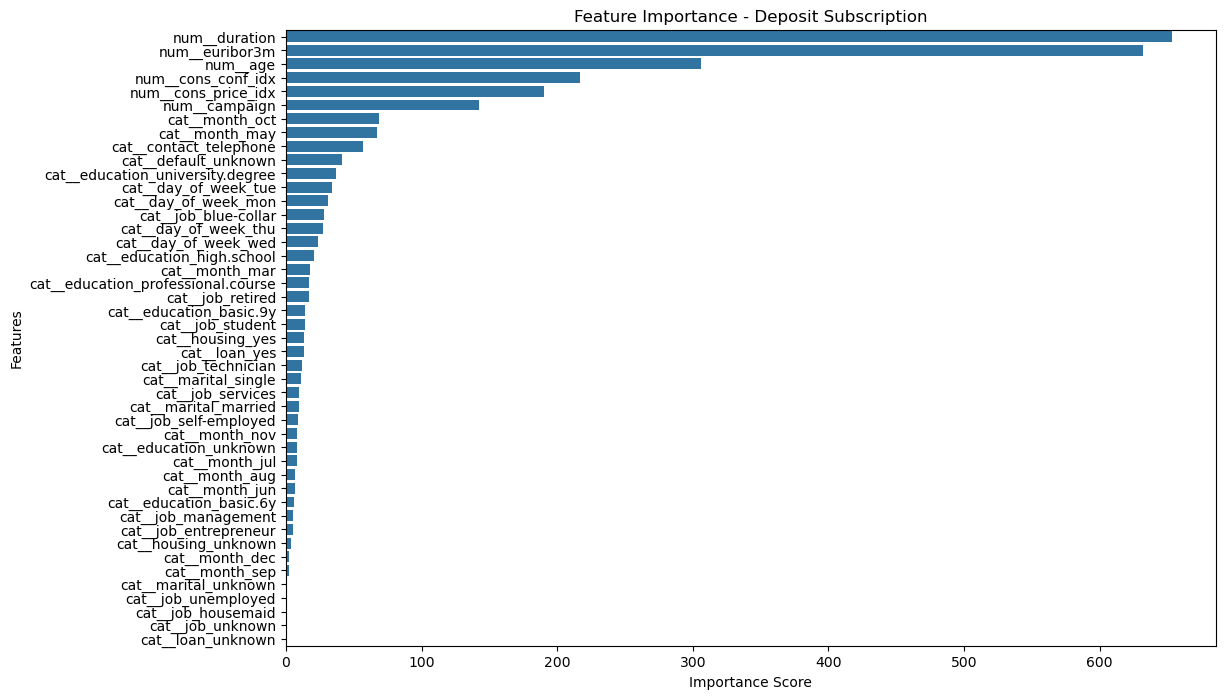

array([306, 653, 142, 190, 217, 632,  28,   5,   1,   5,  17,   9,  10,
        14,  12,   1,   1,  10,  11,   1,   6,  14,  21,  17,  37,   8,
        41,   4,  13,   0,  13,  57,   7,   2,   8,   7,  18,  67,   8,
        69,   2,  31,  27,  34,  24], dtype=int32)

In [235]:
# Extract feature names from the preprocessor and importances from the classifier
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Deposit Subscription')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

final_model.named_steps['classifier'].feature_importances_

In [250]:
import shap

X_transformed = final_model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(final_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_transformed)
shap_values.shape

(8238, 45)

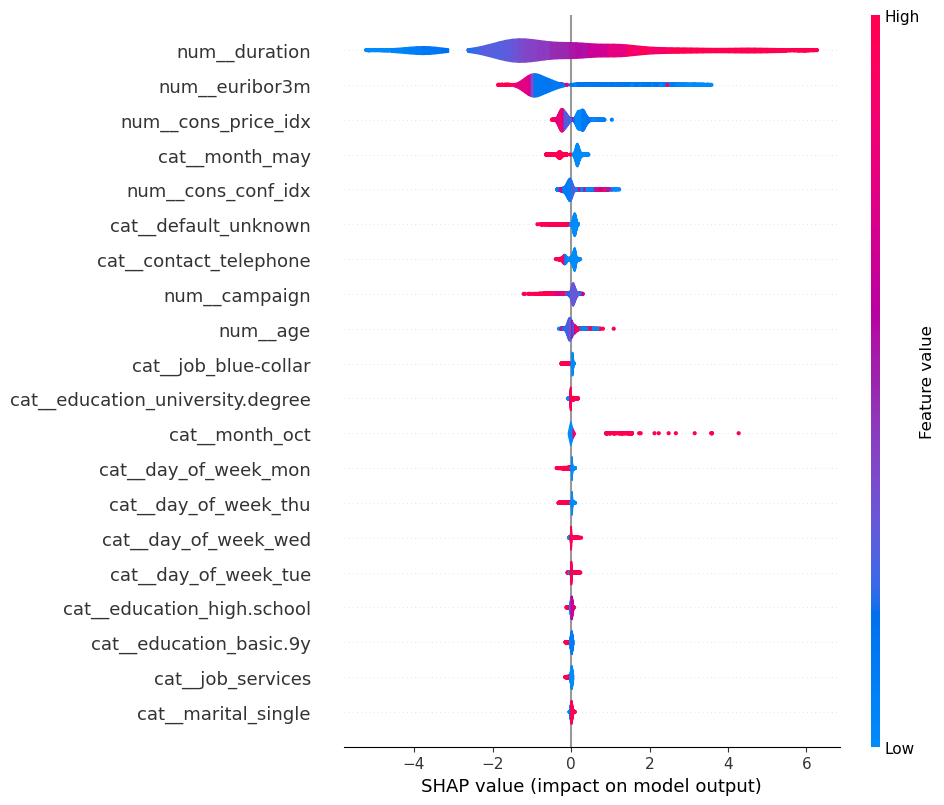

In [ ]:
shap_values_to_plot = shap_values

# summary plot
shap.violin_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)
# shap.summary_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)

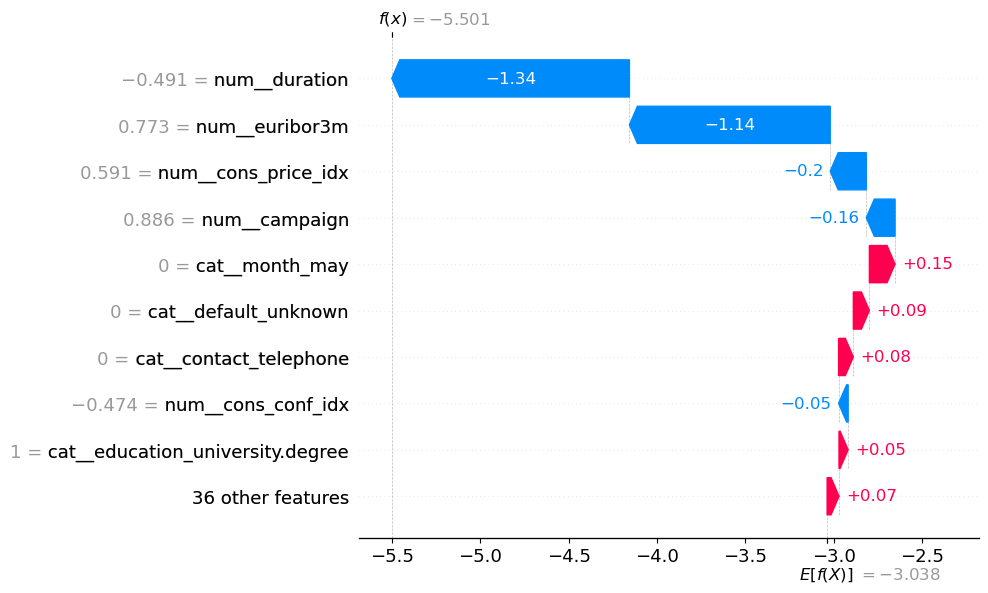

In [268]:
X_df = pd.DataFrame(X_transformed, columns=feature_names)

explanation = explainer(X_df)

# single row's shap contribution
shap.plots.waterfall(explanation[0])

In [242]:
X_df

,num__age,num__duration,num__campaign,num__cons_price_idx,num__cons_conf_idx,num__euribor3m,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,...,cat__month_jun,cat__month_mar,cat__month_may,cat__month_nov,cat__month_oct,cat__month_sep,cat__day_of_week_mon,cat__day_of_week_thu,cat__day_of_week_tue,cat__day_of_week_wed
0,-0.770330,-0.490893,0.886316,0.590675,-0.473517,0.773448,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.289722,-0.610597,-0.567023,-1.058152,-0.062987,-1.357472,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.170659,-0.490893,-0.203688,1.103451,0.045048,-1.617860,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.383130,-0.811391,-0.203688,1.535081,-0.279055,0.773448,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.154817,-0.440694,-0.203688,-1.265334,-2.050821,-1.202507,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,0.767617,1.802792,-0.567023,-1.179008,-1.229759,-1.340766,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8234,-0.962573,-0.382773,-0.567023,-1.179008,-1.229759,-1.364385,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8235,-0.674208,0.825852,-0.567023,0.827208,0.153082,-1.669708,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8236,0.383130,1.582691,1.612985,0.721890,0.887717,0.714111,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [291]:
# select the transformed feature name that contains 'duration' and plot its SHAP scatter
dur_ind = np.where(feature_names=='num__age')[0][0]
age_ind = np.where(feature_names=='num__duration')[0][0]
dur_ind

np.int64(0)

In [315]:
explanation.feature_names

['num__age',
 'num__duration',
 'num__campaign',
 'num__cons_price_idx',
 'num__cons_conf_idx',
 'num__euribor3m',
 'cat__job_blue-collar',
 'cat__job_entrepreneur',
 'cat__job_housemaid',
 'cat__job_management',
 'cat__job_retired',
 'cat__job_self-employed',
 'cat__job_services',
 'cat__job_student',
 'cat__job_technician',
 'cat__job_unemployed',
 'cat__job_unknown',
 'cat__marital_married',
 'cat__marital_single',
 'cat__marital_unknown',
 'cat__education_basic.6y',
 'cat__education_basic.9y',
 'cat__education_high.school',
 'cat__education_professional.course',
 'cat__education_university.degree',
 'cat__education_unknown',
 'cat__default_unknown',
 'cat__housing_unknown',
 'cat__housing_yes',
 'cat__loan_unknown',
 'cat__loan_yes',
 'cat__contact_telephone',
 'cat__month_aug',
 'cat__month_dec',
 'cat__month_jul',
 'cat__month_jun',
 'cat__month_mar',
 'cat__month_may',
 'cat__month_nov',
 'cat__month_oct',
 'cat__month_sep',
 'cat__day_of_week_mon',
 'cat__day_of_week_thu',
 'ca

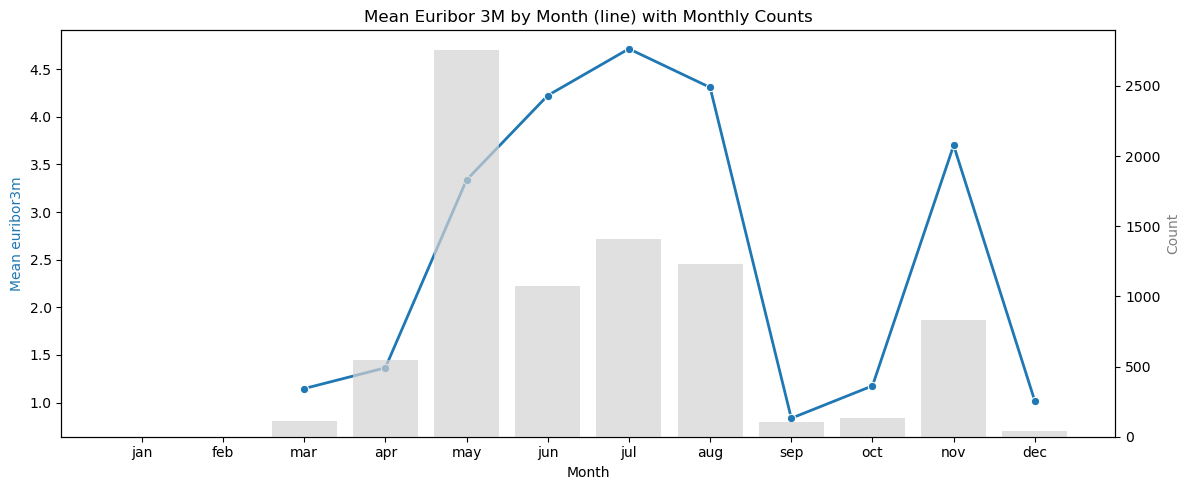

In [346]:
# mean euribor3m by month (ordered) with counts as bars (secondary y-axis)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

mean_euribor = X_test.groupby('month')['euribor3m'].mean().reindex(month_order).reset_index()
month_count = X_test['month'].value_counts().reindex(month_order).fillna(0).reset_index()
month_count.columns = ['month', 'count']

# ensure categorical ordering so jan/feb appear first even if empty
cat_type = pd.CategoricalDtype(month_order, ordered=True)
mean_euribor['month'] = mean_euribor['month'].astype(cat_type)
month_count['month'] = month_count['month'].astype(cat_type)

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()

# bars = counts (secondary y), line = mean euribor
sns.barplot(x='month', y='count', data=month_count, color='lightgray', alpha=0.7, ax=ax2, order=month_order)
sns.lineplot(x='month', y='euribor3m', data=mean_euribor, marker='o', sort=False, ax=ax1, color='tab:blue', linewidth=2)

ax1.set_xlabel('Month')
ax1.set_ylabel('Mean euribor3m', color='tab:blue')
ax2.set_ylabel('Count', color='gray')
ax1.set_title('Mean Euribor 3M by Month (line) with Monthly Counts')

ax1.set_xticklabels(month_order, rotation=0)
fig.tight_layout()
plt.show()

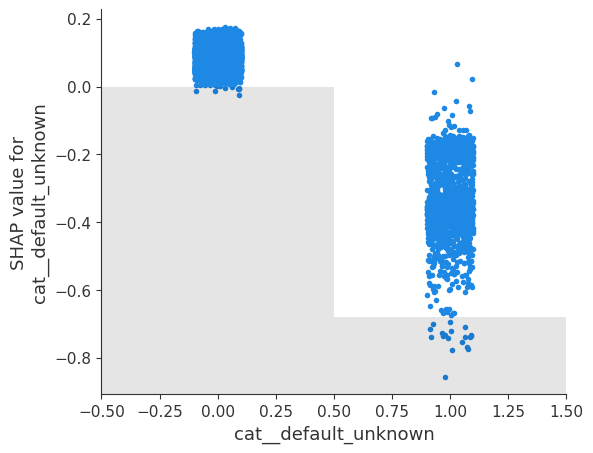

In [355]:
shap.plots.scatter(explanation[:, explanation.feature_names.index('cat__default_unknown')],
                  #  color = explanation[:, explanation.feature_names.index('num__duration')]
                )

#### 1. `Call Duration`

* **Observation**: The distribution for `duration` is the most polarized. While a massive cluster of blue dots (short calls) sits at the neutral/negative line, high-value red dots (long calls) stretch significantly into the positive SHAP zone.
* **Insight**: Call duration is the most powerful "discriminator." While short, routine calls provide almost no predictive lift, there is a clear **engagement threshold**. Once a conversation crosses a certain time limit, the probability of conversion increases exponentially.
* **Possible action**: Because duration is a *post-hoc* metric (captured during the event), it should be used to trigger "Real-Time Next Best Actions" (e.g., if a call exceeds 5 minutes, offer a specific incentive) rather than for pre-call lead filtering.

#### 2. Macroeconomic Sensitivity (Euribor 3M & CPI)

* **Observation**: High interest rates (`euribor3m`) and high consumer price indices (`cons_price_idx`) consistently push SHAP values into the negative.
* **Insight**: The model identifies strong **systemic resistance** during periods of high interest rates and inflation. When the Euribor 3M rate is high, the likelihood of a client locking money into a term deposit drops.
* **Strategic**: Marketing ROI will naturally be lower during these cycles. Strategy should shift toward "Liquidity" messaging rather than "Long-term Savings" during high-rate/high-inflation periods.

#### 3. Temporal Windows: "October Opportunity" vs. "May Decline"

* **Observation**: `month_oct` shows a distinct cluster of red dots with high positive SHAP values, whereas `month_may` is predominantly negative when active.
* **Insight**: Timing emerges as a meaningful non-demographic predictor of subscription behavior. Subscription rates peak in October and decline in May, suggesting a potential seasonal pattern. This trend may also reflect broader economic conditions, as it coincides with movements in Euribor and CPI.
* **Strategic**: Given that the data is collected from less than a single year, it would be prudent to assess whether this pattern is driven by broader market dynamics or reflects a timing effect independent of macroeconomic conditions. The October increase, for example, may also relate to behavioral factors such as proximity to the holiday season, when consumers may be more receptive to financial planning or have greater end-of-year liquidity.

#### 4. Demographic Variance (Age)

* **Observation**: `age` shows significant overlap of red and blue dots across the zero-axis.
* **Insight**: Age displays a non-linear (quadratic-like) influence on converation likelihood. Young and Old cohorts tend to be more likely to subscribe, but other factors also play a role.
* **Note**: Avoid "Age-bucket" targeting (e.g., "all people over 50"). Instead, use age as a modifier for other behavioral triggers.

---

In [ ]:
# shap.initjs()
# shap.plots.force(explanation[0:1000])
# shap.plots.heatmap(explanation[0:1000])

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">6. Save the Model</p>

<a id="6"></a>


Save the model in folder `/models` for deployment.

In [ ]:
import os
import joblib

# Create the model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# List of models to save
models_to_save = [
    ('logistic_regression', best_log_clf),
    ('linear_svc', best_svc_clf),
    ('decision_tree', best_dt_clf),
    ('random_forest', best_rf_clf),
    ('xgboost', best_xgb_clf),
    ('lightgbm', best_lgbm_clf),
]

# save models
# for model_name, model in models_to_save:
#     model_path = os.path.join('model', f'{model_name}_model.joblib')
#     joblib.dump(model, model_path)
#     print(f"Successfully saved {model_name} to {model_path}")

In [195]:
# save/load metrics
file_path = os.path.join('model', 'model_results.joblib')

# joblib.dump(cv_logs_by_model, file_path)

# load metrics
cv_logs_by_model = joblib.load(file_path)
# (cv_logs_by_model['lgbm']['summary_df'] == loaded_metrics['lgbm']['summary_df'])


In [210]:
# load the two models

import joblib
import os

best_log_clf = joblib.load(os.path.join('model', 'logistic_regression_model.joblib'))
best_svc_clf = joblib.load(os.path.join('model', 'linear_svc_model.joblib'))
best_dt_clf = joblib.load(os.path.join('model', 'decision_tree_model.joblib'))
best_rf_clf = joblib.load(os.path.join('model', 'random_forest_model.joblib'))
best_xgb_clf = joblib.load(os.path.join('model', 'xgboost_model.joblib'))
best_lgbm_clf = joblib.load(os.path.join('model', 'lightgbm_model.joblib'))

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">7. Neural Network Classification (Optional)</p>

<a id="7"></a>

Adding an ANN model just to compare the performance with other models.

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

dl_preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
])  

X_train_transformed = dl_preprocessor.fit_transform(X_train)
X_test_transformed = dl_preprocessor.transform(X_test)

# Define the sequential model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
ann_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                tf.keras.metrics.AUC(name="roc_auc"),
                tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
])

# Early stopping
early_stop = EarlyStopping(
    monitor="val_roc_auc",
    mode="max",
    patience=10,
    restore_best_weights=True
)

classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
class_weight

{0: np.float64(0.5634790341336616), 1: np.float64(4.438308189655173)}

In [31]:
ann_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

In [30]:
history = ann_model.fit(
    X_train_transformed, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
103/103 - 1s - 11ms/step - loss: 0.6252 - pr_auc: 0.2571 - precision: 0.1959 - recall: 0.6151 - roc_auc: 0.7049 - val_loss: 0.5880 - val_pr_auc: 0.3476 - val_precision: 0.2593 - val_recall: 0.7248 - val_roc_auc: 0.7947
Epoch 2/50
103/103 - 0s - 1ms/step - loss: 0.5586 - pr_auc: 0.3483 - precision: 0.2846 - recall: 0.6802 - roc_auc: 0.7840 - val_loss: 0.5146 - val_pr_auc: 0.3950 - val_precision: 0.3284 - val_recall: 0.7025 - val_roc_auc: 0.8300
Epoch 3/50
103/103 - 0s - 985us/step - loss: 0.5261 - pr_auc: 0.3698 - precision: 0.3100 - recall: 0.7084 - roc_auc: 0.8181 - val_loss: 0.5332 - val_pr_auc: 0.4299 - val_precision: 0.3306 - val_recall: 0.7864 - val_roc_auc: 0.8655
Epoch 4/50
103/103 - 0s - 993us/step - loss: 0.4820 - pr_auc: 0.4031 - precision: 0.3286 - recall: 0.7657 - roc_auc: 0.8516 - val_loss: 0.3745 - val_pr_auc: 0.4703 - val_precision: 0.4181 - val_recall: 0.7562 - val_roc_auc: 0.8976
Epoch 5/50
103/103 - 0s - 975us/step - loss: 0.4439 - pr_auc: 0.4378 - precisio

In [36]:
y_proba_nn = ann_model.predict(X_test_transformed).ravel()
y_train_proba_nn = ann_model.predict(X_train_transformed).ravel()

# PR curve points (this is for label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
# precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba_nn)

# Search for the best threshold (optimized for f1)
best_thresh_nn, ann_info  = search_best_threshold(y_train, y_train_proba_nn)
# best_t_nn, f1 = search_best_threshold(precision, recall, thresholds)
print(best_thresh_nn)

y_pred_nn = (y_proba_nn >= best_thresh_nn).astype(int)


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step
0.78122956


In [45]:
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_nn))
# Still not much of an improvement, and interpretation is not as clear as for the lxgm.

[[6608  702]
 [ 173  755]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7310
           1       0.52      0.81      0.63       928

    accuracy                           0.89      8238
   macro avg       0.75      0.86      0.79      8238
weighted avg       0.92      0.89      0.90      8238

ROC-AUC: 0.9419408049908015


## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">8. Model w/o Call Duration</p>

<a id="8"></a>

Considering that call duration is mostly a post-hoc variable and in a strictly realistic scenario, it is not possible to know the duration of a call before it takes place.

However, it is the strongest predictor of the target variable. We'll try to remove it from the model and see if the performance degrades significantly.

- Create an XGB model without the duration variable (for speed)

In [ ]:
X_new = X_train.drop('duration', axis=1)

# Calculate scale_pos_weight for imbalance
# scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# defined in #2
preprocessor_no_duration

# small_xgb_clf = Pipeline([
#     ('preprocessor', preprocessor_no_duration),
#     ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
# ])

# param_small_xgb = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__gamma': [0, 1, 3], # default is 0
#     'classifier__eta': [0.01, 0.05, 0.1, 0.3],
#     'classifier__max_depth': [1, 2, 3, 4],
#     'classifier__subsample': [0.5, 0.8, 1.0],
#     'classifier__colsample_bytree': [0.5, 0.8, 1.0],
#     'classifier__scale_pos_weight': [scale_pos_weight, 10, None]
# }

# Model capacity (gamma, max_depth)
# param_small_xgb = {
#     'classifier__gamma': [4], # -> 4
#     'classifier__max_depth': [5,6,7], #  -> 7 is better for gap.
#     'classifier__min_child_weight': [3] # -> 3
# }

# Tree # and learning rate
# param_small_xgb = {
#     "classifier__eta": [0.015], #[0.005, 0.01, 0.015, 0.02, 0.05], #search further around 0.01 -> 0.015
#     "classifier__n_estimators": [300], # [200, 300, 400, 500, 600] # no difference. choose 300
# }

# Sampling (generalization)
# param_small_xgb = {
#     'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], # -> 1
#     'classifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1] # -> 0.9
# }

# Class weight 
# param_small_xgb = {
#     'classifier__scale_pos_weight': [None, scale_pos_weight, 10]} # None

# Regularization
# param_small_xgb = {
#     'classifier__reg_lambda':[0], # [0, 0.1, 0.5, 1.0, 5.0], # 0
#     'classifier__reg_alpha': [0.4, 0.5, 0.6] #0.5
# }

grid_small_xgb = GridSearchCV(step_small_xgb_model, param_grid=param_small_xgb, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=1)

start = time.perf_counter()
grid_small_xgb.fit(X_train, y_train)
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")
step_small_xgb_model = grid_small_xgb.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training time: 17.28 seconds


In [132]:
# 3. check cv performance difference
df_rank_sxgb = pd.DataFrame(grid_small_xgb.cv_results_).sort_values('rank_test_score')
df_rank_sxgb['gap'] = df_rank_sxgb['mean_train_score'] - df_rank_sxgb['mean_test_score']

param_cols = df_rank_sxgb.columns.str.startswith('param_classifier__')
df_rank_sxgb.iloc[:15].loc[:, df_rank_sxgb.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]
# df_rank_xgb[df_rank_xgb['param_classifier__max_depth'] < 4].iloc[:10].loc[:, df_rank_xgb.columns.isin(['mean_train_score', 'mean_test_score', 'gap']) | param_cols]


,param_classifier__reg_alpha,param_classifier__reg_lambda,mean_test_score,mean_train_score,gap
1,0.5,0,0.795123,0.814291,0.019168
0,0.4,0,0.795086,0.814515,0.019430
2,0.6,0,0.794692,0.813477,0.018784


In [133]:
# 4. Confirm best model
print("Best parameters:", grid_small_xgb.best_params_)
print("Best AUC-ROC score:", grid_small_xgb.best_score_)

# best model
best_small_xgb_clf = grid_small_xgb.best_estimator_


Best parameters: {'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0}
Best AUC-ROC score: 0.7951226798380201


Best threshold: 0.1350729763507843
{'min_precision': 0.4, 'min_recall': 0.6, 'precision': np.float64(0.40010272213662046), 'recall': np.float64(0.6295797413793104), 'f1': np.float64(0.48927038626609454), 'condition': 'precision>=0.4 & recall>=0.6 (recall)'}

XGBoost Model Performance with the best threshold (Train + Val)

 Cross-Validation Metrics Summary


,train_mean,train_std,val_mean,val_std,gap_mean,gap_percent
metric,,,,,,
accuracy,0.851624,0.002221,0.849165,0.009386,0.002458,0.002887
f1,0.487570,0.005032,0.477745,0.018766,0.009825,0.020151
precision,0.399101,0.004142,0.392301,0.022014,0.006800,0.017039
recall,0.626685,0.015296,0.611533,0.015513,0.015152,0.024177
roc_auc,0.814291,0.004437,0.795123,0.015481,0.019168,0.023540


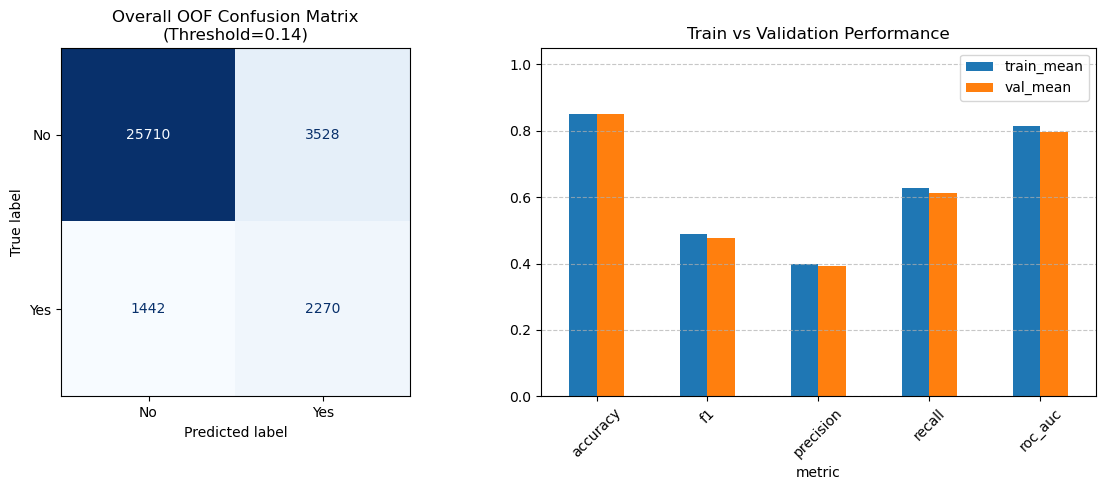

In [146]:
# 5. obtain the best threshold
best_thresh_small_xgb, info_small_xgb = search_best_threshold(y_train,
                                                              best_small_xgb_clf.predict_proba(X_train)[:, 1],
                                                              min_precision=0.4,
                                                              recall_targets=(0.80, 0.70, 0.60),
                                                              objective='recall')
print(f"Best threshold: {best_thresh_small_xgb}")
print(info_small_xgb)
# obtain the train/val performance with the best threshold
print("\nXGBoost Model Performance with the best threshold (Train + Val)")
hist_small_xgb = cv_classification_report_df(best_small_xgb_clf, X_new, y_train, cv=5, threshold=best_thresh_small_xgb)

In [138]:
# Predict on Test Set
ys_test_pred = best_small_xgb_clf.predict(X_test)
ys_test_proba = best_small_xgb_clf.predict_proba(X_test)[:, 1]

print("--- Final Test Set Evaluation (threshold = 0.5) ---")
print(classification_report(y_test, (ys_test_proba>=0.5).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (ys_test_proba>=0.5).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (ys_test_proba>=0.5).astype(int)):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, ys_test_proba):.4f}")

print(f"\n--- Final Test Set Evaluation (threshold = {best_thresh_small_xgb:.2f}) ---")
print(classification_report(y_test, (ys_test_proba>=best_thresh_small_xgb).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (ys_test_proba>=best_thresh_small_xgb).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (ys_test_proba>=best_thresh_small_xgb).astype(int)):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, ys_test_proba):.4f}")

--- Final Test Set Evaluation (threshold = 0.5) ---
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7310
           1       0.61      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.76      0.60      0.63      8238
weighted avg       0.88      0.90      0.87      8238

Confusion Matrix:
 [[7180  130]
 [ 722  206]]
Accuracy: 0.8966
AUC-ROC: 0.8112

--- Final Test Set Evaluation (threshold = 0.14) ---
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7310
           1       0.42      0.64      0.50       928

    accuracy                           0.86      8238
   macro avg       0.68      0.76      0.71      8238
weighted avg       0.89      0.86      0.87      8238

Confusion Matrix:
 [[6473  837]
 [ 334  594]]
Accuracy: 0.8579
AUC-ROC: 0.8112


In [ ]:
# 1. Get the probabilities for the positive class (subscription)
y_proba = best_small_xgb_clf.predict_proba(X_test.drop('duration', axis=1))[:, 1]
 
# 2. Convert probabilities to a 0-100 scale
test_results = pd.DataFrame({
    'Actual': y_test,
    'Probability': y_proba,
    'Lead_Score': (y_proba * 100).astype(int)
})

# 3. Categorize Leads into Tiers
def categorize_lead(score):
    if score > 33: return '1. Hot Lead'
    if score > 8: return '2. Warm Lead'
    return '3. Cold Lead'

test_results['Lead_Tier'] = test_results['Lead_Score'].apply(categorize_lead)

# 4. Analyze the Conversion Rate
conversion_analysis = test_results.groupby('Lead_Tier').agg({
    'Actual': ['count', 'sum', 'mean']
})
conversion_analysis.columns = ['Total Leads', 'Actual Conversions', 'Conversion Rate']
conversion_analysis['Count Percentage'] = conversion_analysis['Total Leads']/conversion_analysis['Total Leads'].sum()
print(conversion_analysis)


              Total Leads  Actual Conversions  Conversion Rate  \
Lead_Tier                                                        
1. Hot Lead           901                 449         0.498335   
2. Warm Lead         1030                 194         0.188350   
3. Cold Lead         6307                 285         0.045188   

              Count Percentage  
Lead_Tier                       
1. Hot Lead           0.109371  
2. Warm Lead          0.125030  
3. Cold Lead          0.765598  


In [368]:
# make Lead_Tier an ordered categorical and sort by tier

tier_order = ['1. Hot Lead', '2. Warm Lead', '3. Cold Lead']
test_results['Lead_Tier'] = pd.Categorical(test_results['Lead_Tier'], categories=tier_order, ordered=True)
test_results = test_results.sort_values('Lead_Tier')
test_results.head()

,Actual,Probability,Lead_Score,Lead_Tier
38439,1,0.485016,48,1. Hot Lead
27928,0,0.420585,42,1. Hot Lead
38447,1,0.493415,49,1. Hot Lead
38283,1,0.368533,36,1. Hot Lead
38544,0,0.469121,46,1. Hot Lead


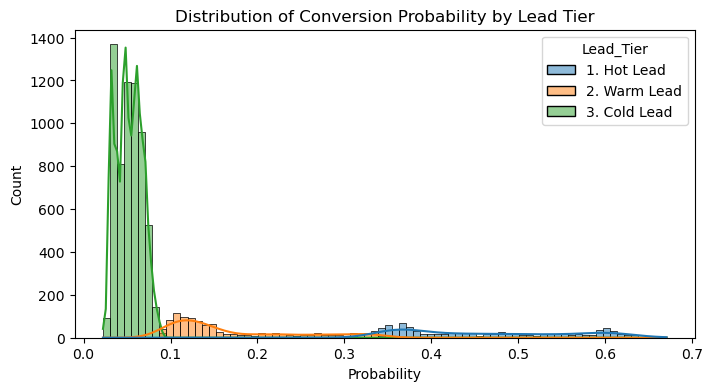

In [369]:
plt.figure(figsize=(8, 4))
sns.histplot(data=test_results, x='Probability', hue='Lead_Tier', kde=True, bins = 80)
plt.title('Distribution of Conversion Probability by Lead Tier')
plt.show()

<a id="9"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">9. Conclusion</p>

We developed a predictive framework to optimize the Portuguese bank's telemarketing efforts for term deposit subscriptions. The main challenges in the dataset are the imbalanced class distribution and the presence of "duration" as a "leaking" variable (i.e., a feature that is highly predictive but practically unuseful for pre-call planning).

We used a two-stage modeling approach:

- **Diagnostic Model:** Included all features (excluding highly correlated ones) to obtain:

    - Features like call duration and economic indicators (euribor3m) were the primary historical drivers of success.
    - Ensembel models (XGBoost, LightGBM) showed strongest overall performance (ROC-AUC). Optimized with a tuned threshold based on the full training dataset, with specific rules (min. precision, min. recall (0.8/0.7/0.6), max f1 under these reqs).

- **"Pre-Call" Predictive Model:** An XGB classifier optimized with a tuned threshold to rank subscription probability without using post-hoc information and group them into separate tiers. Although pure prediction accuracy was not solid, the model is aimed at optimizing lead prioritization, so that limited human calling capacity can be allocated to prospects most likely to convert.

### Model Strategy and Optimization

The transition from a "Cold Calling" approach to a Sales Intelligence model provides the bank with a high-efficiency roadmap for future campaigns. By implementing a tier system, the business can move away from binary predictions and toward a value-based outreach strategy.

#### 1. Efficiency Gains through Tiering
The pre-call model demonstrates that by focusing on the Tier 1 clients, the bank can capture over 50% of all potential subscribers while reducing total call volume by 90%. This represents a massive increase in operational ROI.

- Tier 1 (High Priority): 5x more likely to convert than a random lead; can be designated for senior sales agents.
- Tier 2 (Medium Priority): Conversion rates at around 19%; can be designated for standard outreach.
- Tier 3 (Alternative Outreach): Bottom 80+% of leads; can be removed from the calling queue and handled via low-cost automated email/SMS. [Or conduct further campaigns on seeing if changing contact methods would affect the outcome.]

#### 2. Tactical Recommendations

**Optimized Timing:** The heavy influence of `euribor3m` and `month (oct / may)` suggests that the when is as important as the who. Campaigns should be triggered by specific economic windows or seasons.